# Motif Refinement

Draft motifs identified from an IGR can be refined using this sheet by performing iterative searches taking predicted secondary structure into account.

**Recommended: Restart kernel every time you are working on a new set of data.

## Step 0. Import Necessary Code

Python has basic functions, but to do more advanced functions we need to import additional python packages. The last two lines (from src…) are importing code that is specific and unique to dimpl.


In [1]:
%cd /home/jovyan/work

import sys
import os
import shutil
import pandas as pd
import glob
import tarfile
from Bio import AlignIO, SeqIO
import subprocess
import pandas as pd
import ipywidgets

from src.data.genome_context import get_all_images, run_rscape, tar_subdir_members, build_target_coords
from src.data.command_build import build_infernal_commands

/home/jovyan/work


## Step 1. Set up folders and drop in .sto files

Create a new directory under data/motif_collections.

Create a subdirectory in that new directory with a name for the analysis step (e.g. infernal_step2). Folder/subfolder architecture is required, but folder names can be whatever you want.

Finally, create a directory in the the step directory named "motifs". Place all the .sto files of interest in that directory.

Change the variables in the codeblock below to reflect the collection_name directory and the step directory you just created.

In [2]:
# Change the variables below
collection_name = "riboswitch_candidates"
step_name = "infernal_step2"

In [3]:
# Will move any .sto files found in the data_dir to the /motifs folder
data_dir = "data/motif_collections/{}".format(collection_name)
step_dir = "{}/{}".format(data_dir, step_name)
search_dir = "{}/motifs".format(step_dir)
sto_files = glob.glob("{}/*.sto".format(search_dir))
for sto_file in sto_files:
    motif_name = sto_file[sto_file.rfind('/')+1:-4]
    motif_folder = "{}/{}".format(step_dir, motif_name)
    if not os.path.exists(motif_folder):
        os.mkdir(motif_folder)
    shutil.copyfile(sto_file, "{}/{}.sto".format(motif_folder, motif_name))

# Build the collection of commands required for infernal
build_infernal_commands(data_dir, step_name)
tarfilename = "{}_{}".format(collection_name, step_name)
with tarfile.open("data/export/{}.tar.gz".format(tarfilename), "w:gz") as tar:
    tar.add(data_dir, arcname=tarfilename)
    

## Step 2. Run code on cluster

Move Tarfile to your high-performance cluster. Tarfile is located in data/export.
If you typically log into cluster using `ssh`, you'll be able to use `scp` to do the file transfer. Example command: `scp /path/to/dimple/data/export/tarfilename.tar.gz netid@farnam.hpc.yale.edu:~/project/wherever`.

Untar the uploaded file by using the command `tar xzvf tarfilename`. Remove tarfile using `rm tarfilename.tar.gz` (unpacked files will remain).

Run the script named stepname_run.sh in the newly extracted folder by entering `./stepname_run.sh` into the terminal. If you get a permissions error, run `chmod +x stepname_run.sh` and then try again.

The script will generate a new script to run. Copy and paste to begin analysis.

You can monitor completion of the analysis using the command `squeue -u username` to see running tasks. (PD = pending, R = running)

## Step 3. Compress results
When analysis is complete, compress the results of the analysis on the computational cluster using the command:

`tar czvf riboswitch_candidates_infernal_step2.tar.gz riboswitch_candidates_infernal_step2/`

**Note: be sure to change `collection_name` and `step_name` based on your nomenclature from Step 1.

## Step 4. Move results from cluster to dimpl
Place the downloaded tar.gz file in data/import directory of the DIMPL's file architecture.

Example command: `scp netid@farnam.hpc.yale.edu:~/path/to/tarfile/collection_name_step_name.tar.gz /path/to/dimple/data/import`.

## Step 5. Prep data import
Change the variable `import_tar_name`, `collection_name` and `step_name` below to reflect the data being imported.

In [4]:
# Change the variables here to reflect data being imported
import_tar_name = "data/import/riboswitch_candidates_infernal_step2.tar.gz"
import_collection_name = "riboswitch_candidates"
import_step_name = "infernal_step2"

# Unpack the files 
untar_dir = "data/motif_collections/{}".format(import_collection_name)        
with tarfile.open(import_tar_name, "r:gz") as tar:
    tar.extractall(path=untar_dir, members=tar_subdir_members(tar, import_tar_name))

### Collect all the potential motifs in the imported directory and generate selection dropdown

In [12]:
data_dir = "{}/{}".format(untar_dir, import_step_name)
tblout_files = glob.glob("{}/*/*.tblout".format(data_dir))        
motif_list = list(file.split('/')[-1][:-10] for file in tblout_files)
motif_dropdown = ipywidgets.Dropdown(options=motif_list, description="Motif Name",  layout={'width': 'max-content'})
motif_dropdown

Dropdown(description='Motif Name', layout=Layout(width='max-content'), options=('DUF1646', 'nhaA1', 'nhaAII', …

## Step 6. Analysis

After selecting an IGR from the dropdown below, run cells starting at this codeblock to generate the analysis data.

In [13]:
# Saves the next motif in the list of motifs to motif_name
motif_name=motif_dropdown.value
outdir="{}/{}".format(data_dir,motif_name)
sto_filename = "{}/{}.cm.align.sto".format(outdir, motif_name)
dedupe_filename = "{}/{}.dedupe.fasta".format(outdir, motif_name)
sample_filename = "{}/{}.sample.fasta".format(outdir, motif_name)
results_filename ="{}/{}.cm.tblout".format(outdir, motif_name) 

# Read in the results from the .tblout file
results_df = pd.read_csv(results_filename, skiprows=2, skipfooter=10, sep='\s+', engine='python', header=None, 
                         names=['target_name', 'target_accession', 'query_name', 'query_accession', 'mdl', 'mdl_from', 'mdl_to', 
                                'seq_from', 'seq_to', 'strand', 'trunc', 'pass', 'gc', 'bias', 'score', 'e_value', 'inc','description'])
# Correct coordinates taking IGR database into account
results_df['target_coords'] = results_df.apply(lambda row: build_target_coords(row['target_name'], row['seq_from'], row['seq_to']), axis=1)
results_df.drop(columns=['target_accession', 'query_accession', 'inc', 'description', 'query_name'], inplace=True)

# Remove duplicate entries from the database
dedupe_fasta = list(SeqIO.parse(dedupe_filename, 'fasta'))
dedupe_id_list = [(record.id) for record in dedupe_fasta]
deduped_results_df = results_df[results_df['target_coords'].isin(dedupe_id_list)]

# Output results
print("Results for: {}".format(motif_name))
print("Number of Unique Hits: {}".format(len(dedupe_id_list)))

# Display up to 100 rows
with pd.option_context('display.max_rows', 100):
    display(deduped_results_df[['e_value', 'target_coords', 'gc', 'bias', 'score', 'strand', ]])

Results for: nhaA1
Number of Unique Hits: 861


,e_value,target_coords,gc,bias,score,strand
0,8.200000e-08,NZ_FNDR01000008.1/55059-55137,0.70,0.2,63.1,+
1,2.400000e-07,NC_012791.1/1124715-1124795,0.70,0.5,61.2,+
4,3.200000e-07,NC_022247.1/1191990-1192069,0.70,0.7,60.7,+
5,4.200000e-07,NC_008825.1/404707-404778,0.74,0.4,60.2,+
7,5.100000e-07,NZ_RQXU01000019.1/29853-29933,0.69,0.9,59.9,+
...,...,...,...,...,...,...
1857,8.300000e-03,NZ_KB850033.1/1792-1858,0.54,0.0,42.9,+
1858,8.700000e-03,NZ_LOCQ01000062.1/341597-341664,0.62,0.0,42.8,+
1867,9.100000e-03,NZ_NERY01000002.1/10942-11010,0.55,0.0,42.7,+
1869,9.700000e-03,NZ_JQGJ02000001.1/53874-53950,0.62,0.0,42.6,+


### 6.1 RNAcode Analysis for Possible Protein Coding Regions

Regions with a p-value < 0.05 are indicative of protein coding regions. SVG images of any such regions will be placed in the motif subfolder.

In [15]:
clustal_filename = "{}/{}/{}.sample.clustal".format(data_dir,motif_name, motif_name) 

sample_fasta = list(SeqIO.parse(sample_filename, 'fasta'))
sample_id_list = [record.id for record in sample_fasta]
sto_records = list(SeqIO.parse(sto_filename, 'stockholm'))
sampled_sto_records = [record for record in sto_records if record.id in sample_id_list]

alignment = sampled_sto_records[:200]

with open(clustal_filename, 'w') as clustal_file:
    SeqIO.write(alignment, clustal_file, "clustal")
    
output = subprocess.run(['RNAcode', clustal_filename], capture_output=True)

print(output.stdout.decode())
print(output.stderr.decode())


. 56 sites are made from completely undetermined states ('X', '-', '?' or 'N')...

 HSS # Frame Length  From    To        Name       Start         End    Score        P
     0    +2      5     2     6NZ_FNDR01000008.1/55059-55137           5          19     4.98    0.167
     1    +1      3    24    26NZ_FNDR01000008.1/55059-55137          70          78     0.83    0.983

1 alignment(s) scored in 8.87 seconds. Parameters used:
N=100, Delta=-10.00, Omega=-4.00, omega=-2.00, stop penalty=-8.00





## 6.2 R-scape De-Novo Structure Prediction

When fold=true, will use predictive mode to build the best consensus structure with the largest possible number of significantly covarying pairs, including predicting psuedoknots.

After running the code block, a preview of the generated .svg will appear, containing the consensus and any predicted pseudoknots. An SVG images will be placed in the motif subfolder.

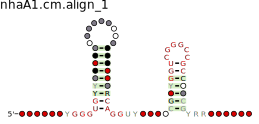

In [16]:
# change output=True to see R-scape table
run_rscape(outdir, sto_filename, fold=True, output=False)

## 6.3 CMfinder Realigned Structure

CMFinder outputs its best folding prediction as a file ending in `cmfinder.realign.sto`. This codeblock will run that realign file through R-scape to evaluate a the structure for covariation. Because fold=False, it will not find psuedoknots unless they were already predicted in the structure.

After running the code a preview of the generated .svg will appear. An SVG image will be placed in the motif subfolder.

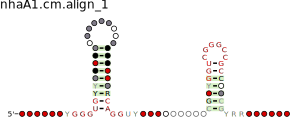

In [17]:
# change output=False to see R-scape table
realign_filename = "{}/{}.cmfinder.realign.sto".format(outdir, motif_name)
run_rscape(outdir, realign_filename, fold=False, output=False)

## 6.4 CMfinder Analyzed Submotifs

CMFinder will often generate several submotifs and use the submotifs to find the 'best' version and output it as the `cmfinder.realign.sto` file.

Running this code will show you all submotifs. SVG images for each submotif will be placed in the motif subfolder.

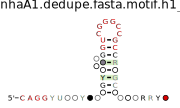

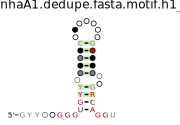

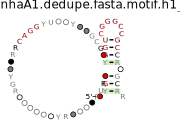

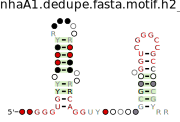

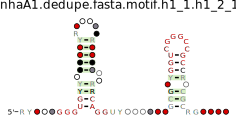

In [18]:
with open("{}/motif.list".format(outdir), "r") as motif_list_file:
    motif_list = motif_list_file.read().split('\n')
    
motif_list.remove("")
motif_list = ["{}/{}".format(untar_dir,motif) for motif in motif_list ]
for file in motif_list:
    renamed_file = "{}.sto".format(file)
    if not os.path.isfile(renamed_file):
        os.rename(file, renamed_file)
    run_rscape(outdir, renamed_file, fold=False, output=False)

## Genome Context Images

Match #1
E-value: 8.199999999999999e-08
%GC: 0.7
Score: 63.1
Genome Assembly: GCF_900099805.1_IMG-taxon_2687453678_annotated_assembly
Target: NZ_FNDR01000008.1/55059-55137
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Variovorax; unclassified Variovorax
Matched Sequence: UGGGGCCGGGUGCGGAGCCgcuuGUcuuccauGCGGUGCCGCAGGUUCAUGCGAUGGUCGGGCCGCCACGCGGAUUCGU


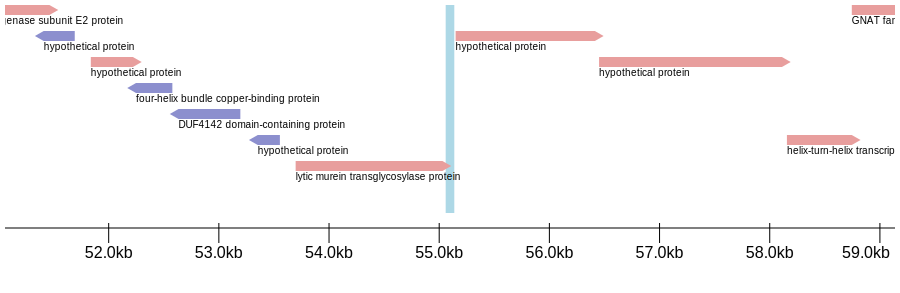

Match #2
E-value: 2.4e-07
%GC: 0.7
Score: 61.2
Genome Assembly: GCF_000023345.1_ASM2334v1
Target: NC_012791.1/1124715-1124795
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Variovorax; Variovorax paradoxus
Matched Sequence: UGGGGCUGGGUGCGGGGCCgcuugcuucuuguugGCGGCGCCGCAGGUUCAUGCGAUGGUCGGGCCGCCACGCGGAUCAAC


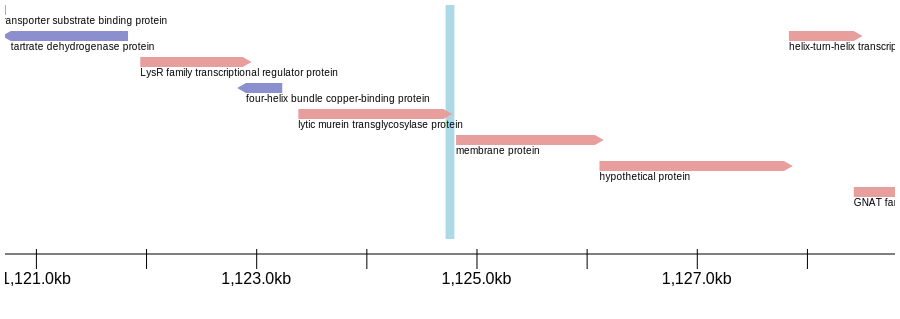

Match #5
E-value: 3.2e-07
%GC: 0.7
Score: 60.7
Genome Assembly: GCF_000463015.1_ASM46301v1
Target: NC_022247.1/1191990-1192069
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Variovorax; Variovorax paradoxus
Matched Sequence: UGGGGCCGGGUGCGGGGCCgcuugUcuuucuuuGCGGCGCCGCAGGUUCAUGCGAUGGUCGGGCCGCCACGCGGAUCAGU


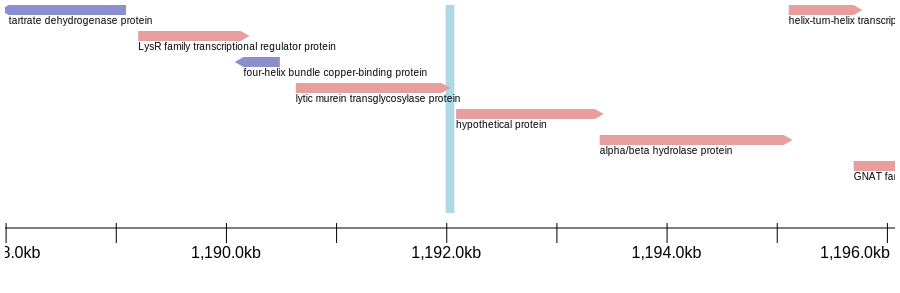

Match #6
E-value: 4.2e-07
%GC: 0.74
Score: 60.2
Genome Assembly: GCF_000015725.1_ASM1572v1
Target: NC_008825.1/404707-404778
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Burkholderiales genera incertae sedis; Methylibium; Methylibium petroleiphilum
Matched Sequence: UCCCCCCGGGUGUCGGACCgcGAGcGCGGUGCGGCAGGUUCAUGCGAAGGUCGGGCCGCCUCGCGGUUGCUU


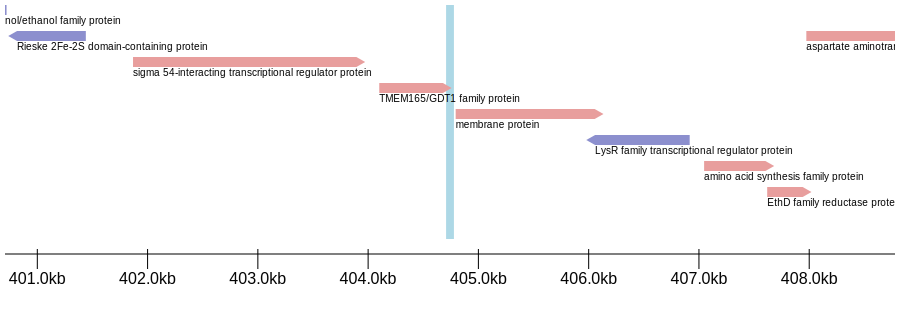

Match #8
E-value: 5.1e-07
%GC: 0.69
Score: 59.9
Genome Assembly: GCF_003863415.1_ASM386341v1
Target: NZ_RQXU01000019.1/29853-29933
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Variovorax; unclassified Variovorax
Matched Sequence: UGGGGCUGGGUGCGGGGCCgcuugcuucuuguuuGCGGCGCCGCAGGUUCAUGCGAUGGUCGGGCCGCCACGCGGAUCAGU


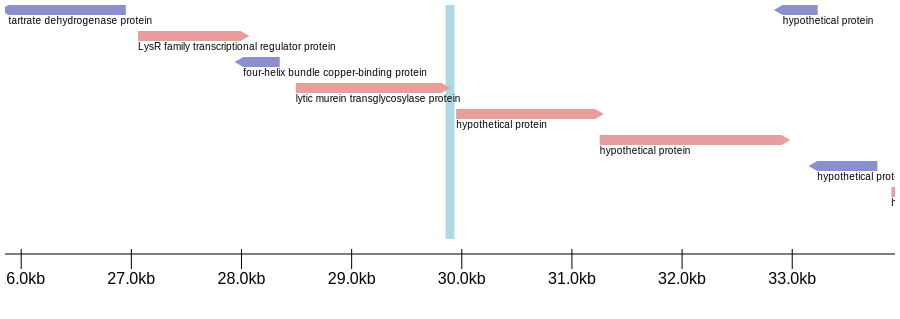

Match #12
E-value: 5.8e-07
%GC: 0.74
Score: 59.7
Genome Assembly: GCF_007828835.1_ASM782883v1
Target: NZ_VIVL01000002.1/157369-157448
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Variovorax; unclassified Variovorax
Matched Sequence: UGGGGCCGGGUGCGGGGCCcuugcuucugguugGCGGCGCCGCAGGUUCAUGCGAUGGUCGGGCCGCCACGCGGAUCAGC


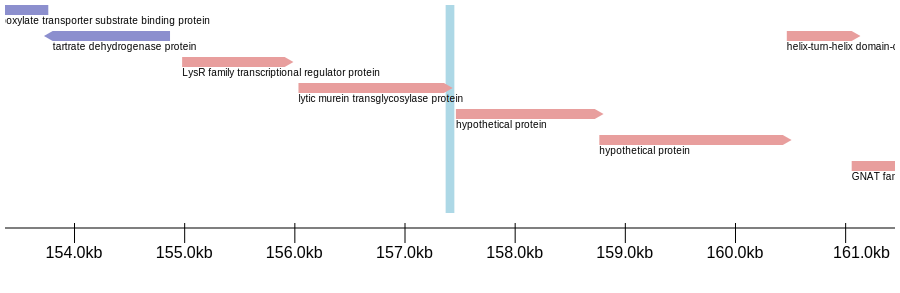

Match #14
E-value: 6.8e-07
%GC: 0.71
Score: 59.4
Genome Assembly: GCF_001425905.1_Root1272
Target: NZ_LMDY01000008.1/9883-9952
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Burkholderiales genera incertae sedis; Methylibium; unclassified Methylibium
Matched Sequence: CCGAACAGGGUGUCGGACCGCGCGCGGUGCGGCAGGUUCAUGCGAAGGUCGGGCCGCCUCGCGGAUGCUU


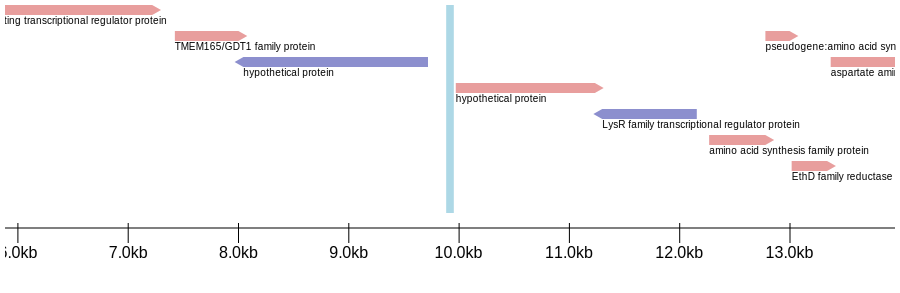

Match #20
E-value: 1e-06
%GC: 0.65
Score: 58.6
Genome Assembly: GCF_000787715.1_ASM78771v1
Target: NZ_BBPI01000066.1/10586-10657
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Sphingomonadales; Sphingomonadaceae; Sphingomonas; Sphingomonas parapaucimobilis
Matched Sequence: CGCCUUCGGGUGUUCGCAGAUCGCUGGUGCGGGCAGGUUCUAACGUUGGUCGGGCCGCCAACGCGGAAUCCU


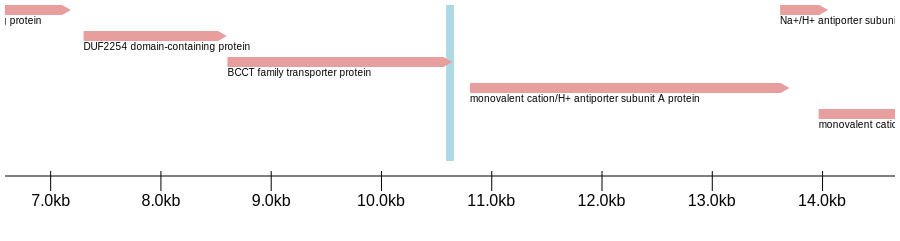

Match #23
E-value: 1.1e-06
%GC: 0.65
Score: 58.6
Genome Assembly: GCF_000802385.1_ASM80238v1
Target: NZ_JTDN01000001.1/2084797-2084873
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Sphingomonadales; Erythrobacteraceae; Croceibacterium
Matched Sequence: CGUCCUUGGGUGUCUGCUGccgauCUuguCGCAGCAGACAGGUUCUUGCGCUGGUCGGGCCGCCAGCGACGAUCUCC


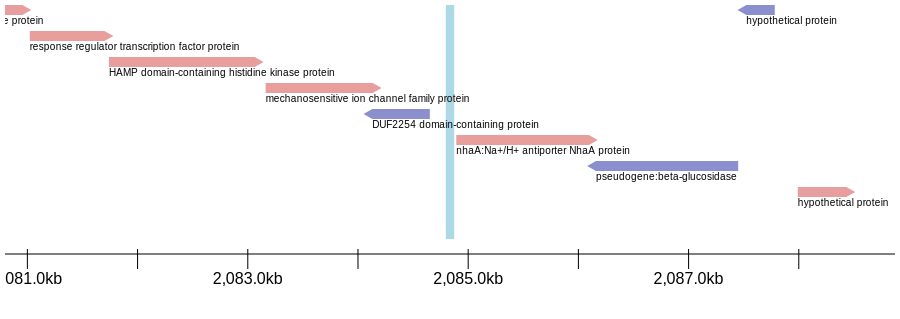

Match #24
E-value: 1.1e-06
%GC: 0.74
Score: 58.6
Genome Assembly: GCF_000333655.1_Methylobacterium_sp._MB200_genome_sequence_1.0
Target: NZ_KB316282.1/1039032-1039104
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Rhizobiales; Methylobacteriaceae; Methylobacterium; unclassified Methylobacterium
Matched Sequence: CCCGCCAGGGUGCGCGGUCcgACAGUCGGACCGGCAGGUUUUCGCGCUGGUCGGGCCGCCAGCGGCAGGAAAG


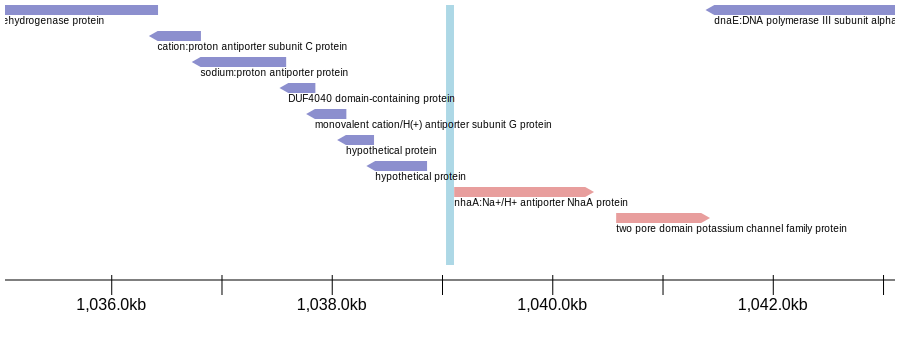

Match #26
E-value: 1.1e-06
%GC: 0.67
Score: 58.5
Genome Assembly: GCF_003605735.1_ASM360573v1
Target: NZ_QXTJ01000040.1/142406-142484
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; unclassified Pseudomonas
Matched Sequence: UCGCGGUGGGUGCGCUGCUgcAUACGGCACAGCGCAGGUUAAAGcucaagCGCUGGUCGGGCCGCCAGCGGAGAGUCAC


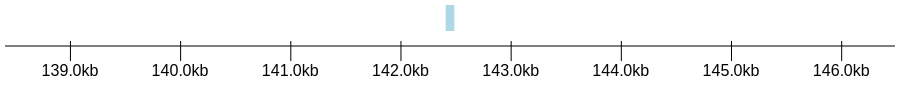

Match #29
E-value: 1.2e-06
%GC: 0.6
Score: 58.4
Genome Assembly: GCF_000211795.1_SphS17_1.0
Target: NZ_AFGG01000006.1/71330-71401
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Sphingomonadales; Sphingomonadaceae; Sphingomonas; unclassified Sphingomonas
Matched Sequence: CGGCUCUGGGUGUUCGCAAaAUGCUGAUGCGGACAGGUUCUAACGUUGGUCGGGCCGCCAACGGGGAAUCCU


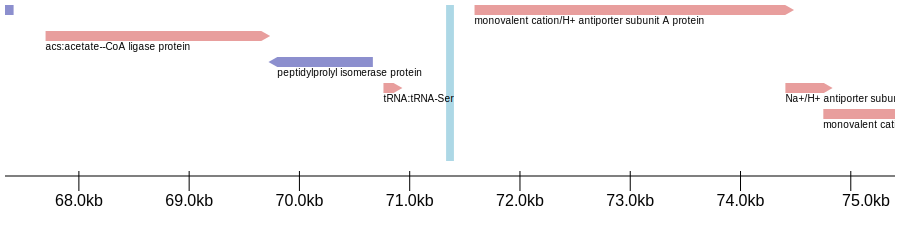

Match #36
E-value: 1.3e-06
%GC: 0.65
Score: 58.2
Genome Assembly: GCF_009755665.1_ASM975566v1
Target: NZ_CP046622.1/1128146-1128216
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Variovorax
Matched Sequence: UGGCAUCGGGUGCGAGGCCuUUCUCUGGCGUCGCAGGUUCUAGCGAUGGUCGGGCCGCCACGCGGUUCAUU


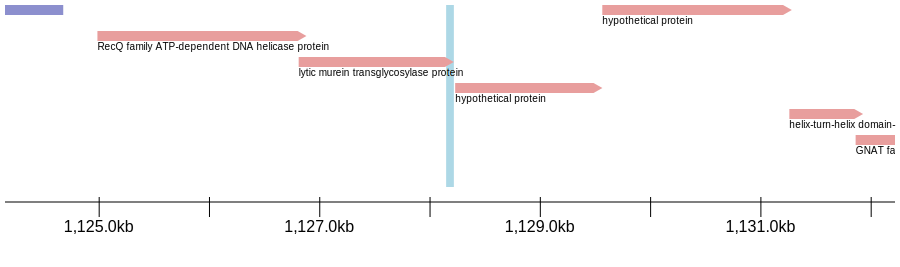

Match #43
E-value: 1.6e-06
%GC: 0.7
Score: 57.9
Genome Assembly: GCF_003797765.1_ASM379776v1
Target: NZ_RKMB01000002.1/191606-191672
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Ramlibacter; unclassified Ramlibacter
Matched Sequence: UAACGACGGGUGCCGCAUCCCUCGAUGCGGCAGGUUCAGCGACGGUCGGGCCGCCUCGCGGCUUUGC


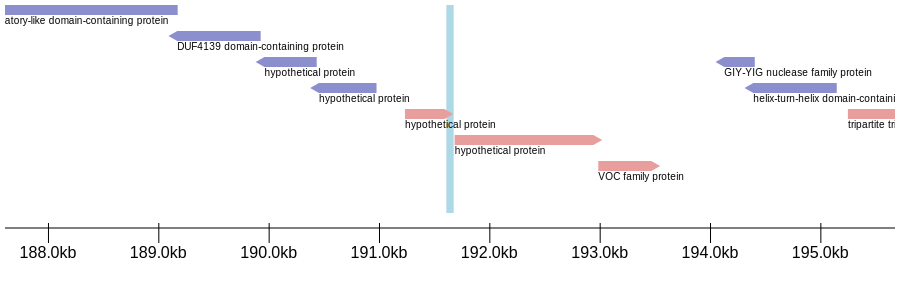

Match #45
E-value: 1.8e-06
%GC: 0.75
Score: 57.7
Genome Assembly: GCF_004136295.1_ASM413629v1
Target: NZ_CP029606.1/2308886-2308957
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Burkholderiales genera incertae sedis; Methylibium; unclassified Methylibium
Matched Sequence: CCCUCCCGGGUGUCGGACCgcGAGcGCGGUGCGGCAGGUUCACGCGAAGGUCGGGCCGCCUCGCGGUUGCUU


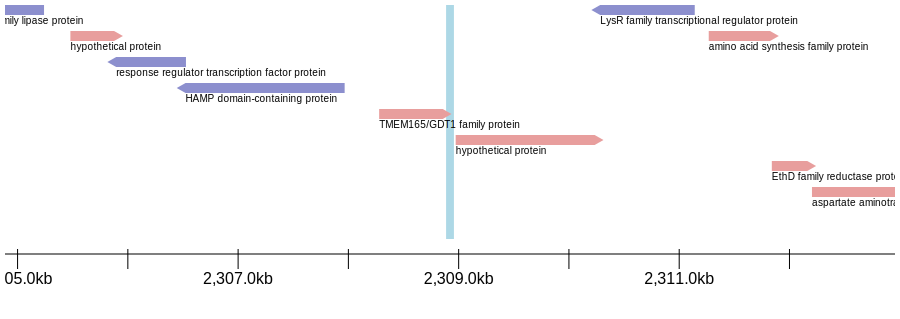

Match #46
E-value: 1.8e-06
%GC: 0.74
Score: 57.6
Genome Assembly: GCF_900113035.1_IMG-taxon_2634166330_annotated_assembly
Target: NZ_FONX01000003.1/62388-62455
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Acidovorax
Matched Sequence: GCAGCCUGGGUGGCGCGCCAUGCGGGCGCGCCAGGUAUAGCGAAGGUCGGGCCGCCUCGCGGUUUCCU


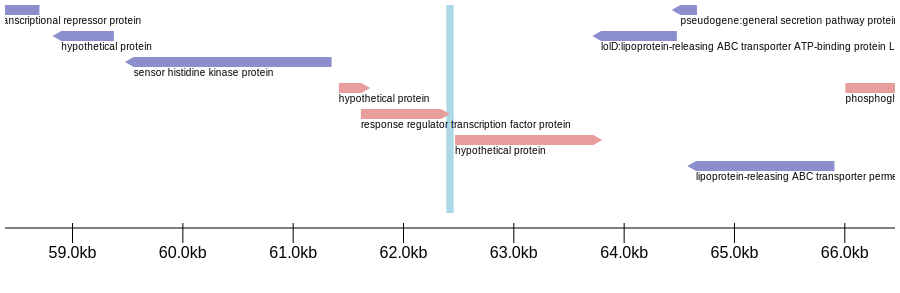

Match #49
E-value: 2e-06
%GC: 0.71
Score: 57.5
Genome Assembly: GCF_002858925.1_ASM285892v1
Target: NZ_PJRS01000006.1/16554-16623
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Caulobacterales; Caulobacteraceae; Caulobacter
Matched Sequence: CGCCUACGGGUGCCCGGCCAUCUUGGCCGGUCAGGAUUCUCCGCUGGUCGGGCCGCCAGCGCGGAGAAAC


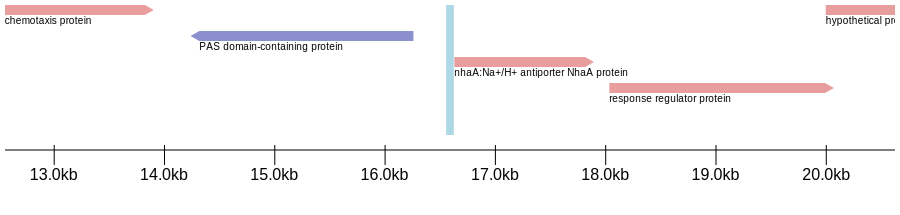

Match #50
E-value: 2e-06
%GC: 0.66
Score: 57.5
Genome Assembly: GCF_002837135.1_ASM283713v1
Target: NZ_NWBQ01000095.1/9433-9502
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Macromonas
Matched Sequence: UCGCGCUGGGUGUCAAGCGCGUUcUGGCUUGGCAGGUUCAUGCGCAGGUCGGGCCGCCGCGCGGUUUUUU


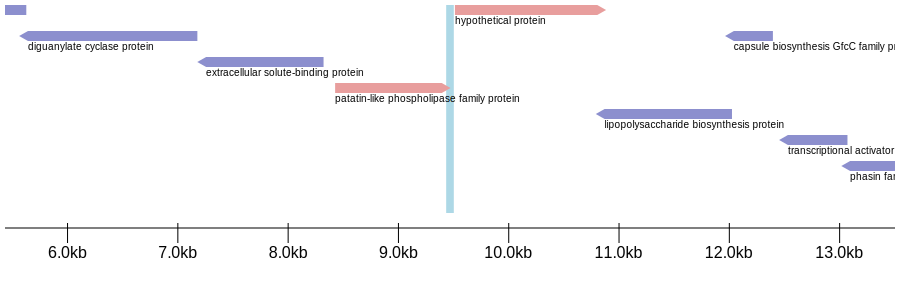

Match #51
E-value: 2e-06
%GC: 0.67
Score: 57.5
Genome Assembly: GCF_001274695.1_ASM127469v1
Target: NZ_LARU01000004.1/223768-223836
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Rhodocyclales; Zoogloeaceae; Azoarcus; unclassified Azoarcus
Matched Sequence: UCGCGCCGGGUGCUCACGCaAUCAAGCGUGGCAGGUUGAUGCGAUGGUCGGGCCGCCUCGCGGCUUUUC


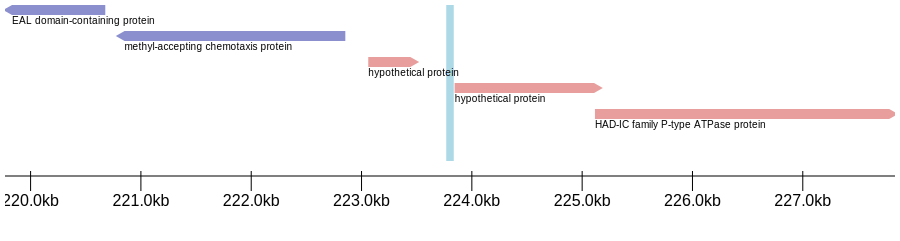

Match #55
E-value: 2.3e-06
%GC: 0.68
Score: 57.3
Genome Assembly: GCF_000761155.1_ASM76115v1
Target: NZ_CP009533.1/1400495-1400572
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas
Matched Sequence: UCGCCGCGGGUGCGCCGCUgcAUAGGGUACGGCGCAGGUUAAAGuucagCGUUGGUCGGGCCGCCAACGGAGACGUCC


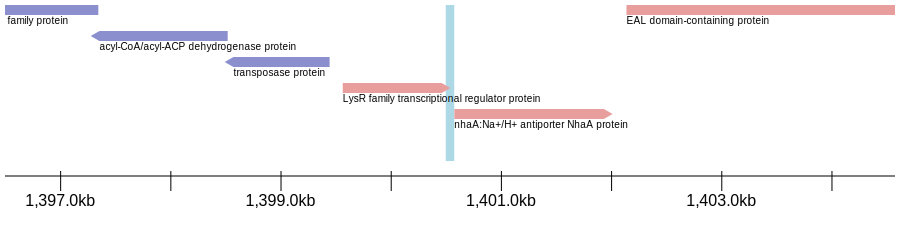

Match #69
E-value: 3.2e-06
%GC: 0.7
Score: 56.6
Genome Assembly: GCF_001556145.1_ASM155614v1
Target: NZ_LSIH01000232.1/6923-6992
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Acidovorax
Matched Sequence: UGGAGAUGGGUGUCGGCGCcAUCGUGGCCCGGCAGGUUCAUGCGCUGGUCGGGCCGCCGCGCGGUUUUUC


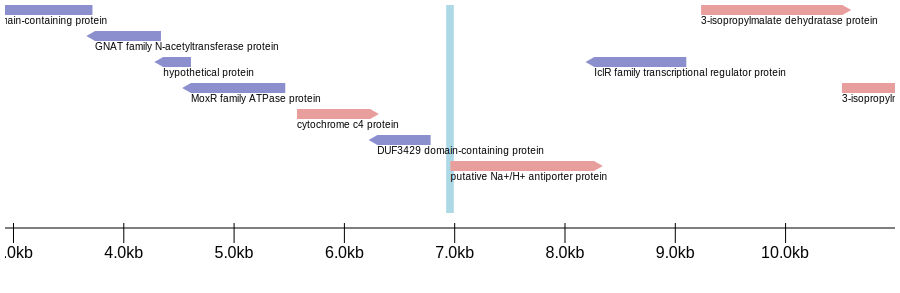

Match #70
E-value: 3.500000000000001e-06
%GC: 0.59
Score: 56.5
Genome Assembly: GCF_000971055.1_SRS2_1.0
Target: NZ_LARW01000054.1/40361-40433
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Sphingomonadales; Sphingomonadaceae; Sphingomonas; unclassified Sphingomonas
Matched Sequence: AGAUCAUGGGUGUCCGCUUgcAUGCUGCAGCGGACAGGUAUCUGUGCUGGUCGGGCCGCCAGCAAGAAAUCUC


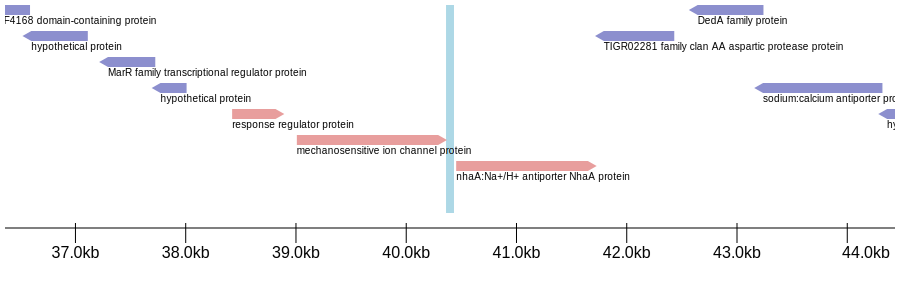

Match #71
E-value: 3.500000000000001e-06
%GC: 0.6
Score: 56.5
Genome Assembly: GCF_003050705.1_ASM305070v1
Target: NZ_QAOG01000007.1/225470-225537
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Sphingomonadales; Sphingomonadaceae; Sphingomonas
Matched Sequence: GCGCGACGGGUGCUCUCAUGUCAAUGGGGCAGGUUUUUACGCUGGUCGGGCCGCCAGCGCUGAAAAUU


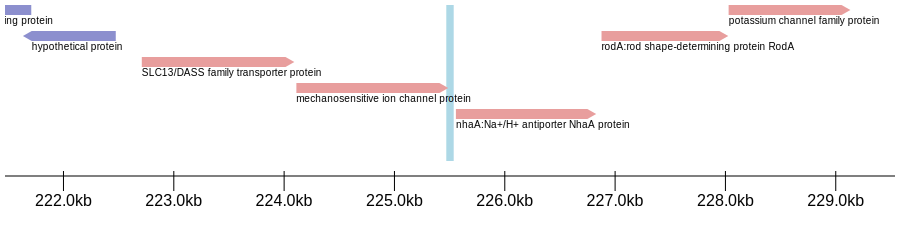

Match #73
E-value: 3.7000000000000006e-06
%GC: 0.71
Score: 56.4
Genome Assembly: GCF_001262595.1_ASM126259v1
Target: NZ_LHCD01000002.1/221837-221909
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Rhizobiales; Methylobacteriaceae; Methylobacterium; unclassified Methylobacterium
Matched Sequence: CCGCCCCGGGUGUACGAUCcgGAGGUCGGAUCGGCAGGUUUCUGCGUUGGUCGGGCCGCCAGCGGCGGAAGAC


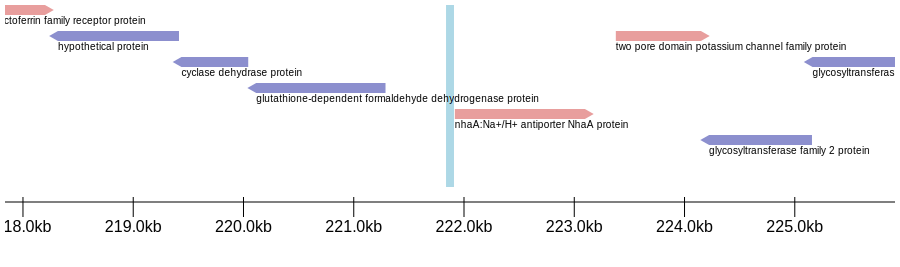

Match #77
E-value: 4.3e-06
%GC: 0.74
Score: 56.1
Genome Assembly: GCF_008000895.1_ASM800089v1
Target: NZ_CP042823.1/2866324-2866396
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Rhizobiales; Methylobacteriaceae; Methylobacterium; unclassified Methylobacterium
Matched Sequence: CGGCCAUGGGUGCGCGGUCcgACCUUCGGACCGGCAGGCUUCAGCGUUGGUCGGGCCGCCAGCGCGGGAGAUC


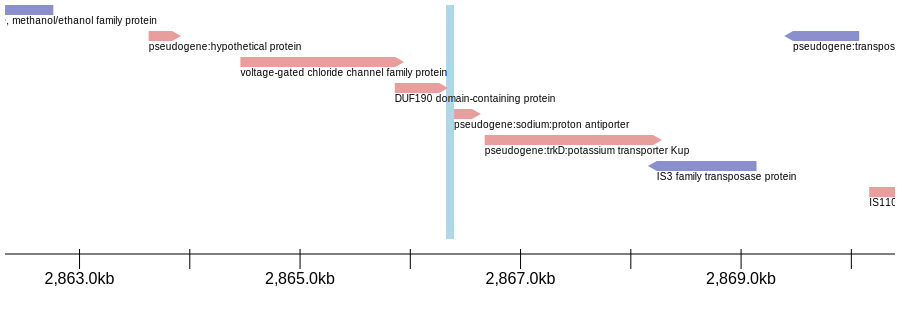

Match #86
E-value: 5e-06
%GC: 0.68
Score: 55.9
Genome Assembly: GCF_001477625.1_ASM147762v1
Target: NZ_CP013692.1/1389255-1389328
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Burkholderiales genera incertae sedis; Paucibacter; unclassified Paucibacter
Matched Sequence: UGCCUCCGGGUGCUUGGCCgcaAUGGGCGGCUGGGCAGGUGAACAgCGAAGGUCGGGCCGCCUCGCCAAUUUUG


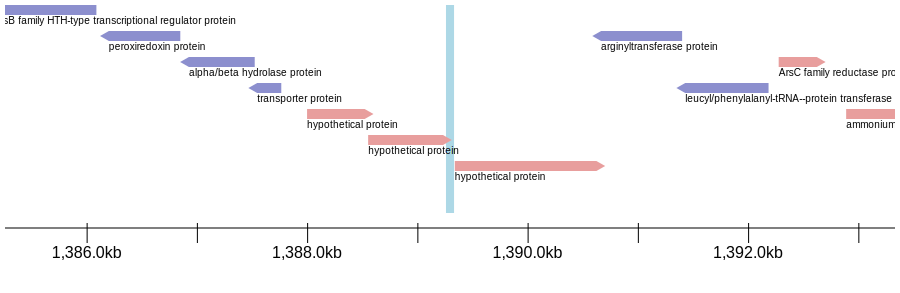

Match #87
E-value: 5e-06
%GC: 0.64
Score: 55.9
Genome Assembly: GCF_001429065.1_Root710
Target: NZ_LMIB01000012.1/897403-897475
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Sphingomonadales; Sphingomonadaceae; Sphingomonas; unclassified Sphingomonas
Matched Sequence: AAAGCUCGGGUGCUCGCUUcccgacuGCAGCGAGCAGGUAUCUGUGCUGGUCGGGCCGCCAGCAGGGCUUAUC


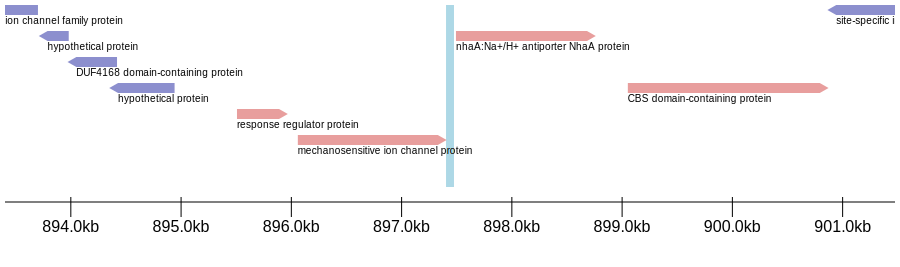

Match #89
E-value: 5.2e-06
%GC: 0.71
Score: 55.8
Genome Assembly: GCF_004336745.1_ASM433674v1
Target: NZ_SJXD01000029.1/84100-84171
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Rhodospirillales; Acetobacteraceae; Roseococcus; unclassified Roseococcus
Matched Sequence: GCCGGCCGGGUGUCGGCGCuUCACGGGCGUGGACAGGUUUCAGCGUUGGUCGGGCCGCCAACGCUGGUGAUC


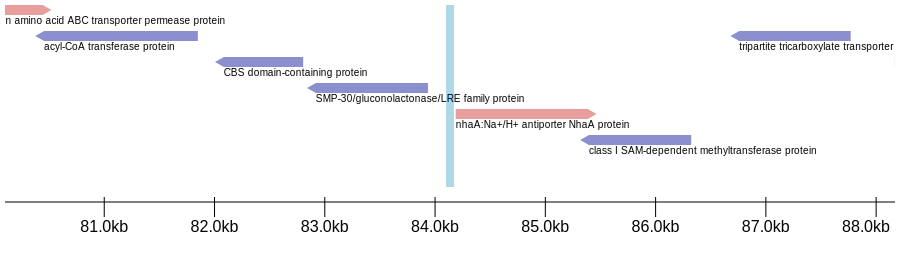

Match #92
E-value: 5.400000000000002e-06
%GC: 0.62
Score: 55.7
Genome Assembly: GCF_900089455.2_OrrDiv2
Target: NZ_LT907988.1/3427885-3427956
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Alcaligenaceae; Orrella
Matched Sequence: UGGUCGCGGGUUUUGGUCUcgCCAUGAGGCCAAGAGGUGAUUGCGUUGGUCGGGCCGCCAACGCGGGCUUAU


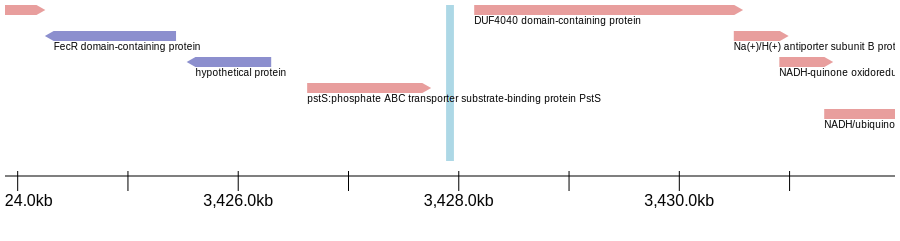

Match #98
E-value: 5.8e-06
%GC: 0.74
Score: 55.6
Genome Assembly: GCF_001422985.1_Leaf117
Target: NZ_LMNL01000005.1/21770-21843
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Rhizobiales; Methylobacteriaceae; Methylobacterium; unclassified Methylobacterium
Matched Sequence: ACCCUUCGGGUGCAGGGUCcggAGGGUCGGACCCGCAGGCUUCAGCGCUGGUCGGGCCGCCAGCGACGGAGACC


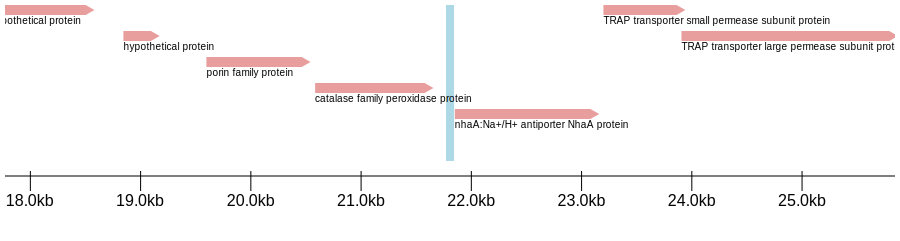

Match #106
E-value: 6.5e-06
%GC: 0.73
Score: 55.4
Genome Assembly: GCF_001509835.1_ASM150983v1
Target: NZ_JXTJ01000006.1/238619-238693
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Rhizobiales; Bradyrhizobiaceae; Bosea; unclassified Bosea
Matched Sequence: AGGGCCCGGGUGCUCCGCCgcgAUCGUGCGGCGGGCAGGUUUUUUgCGCUGGUCGGGCCGCCAGUGCGAGGAGAC


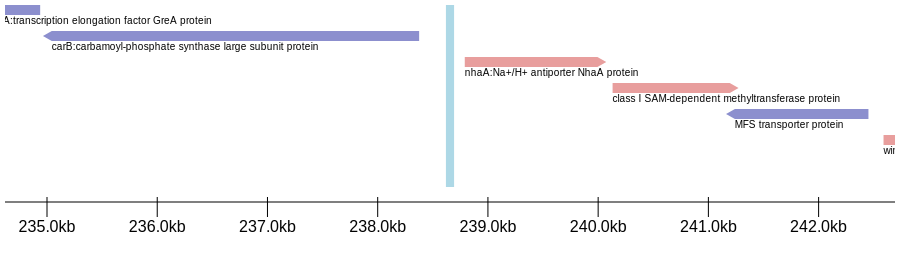

Match #107
E-value: 6.8e-06
%GC: 0.65
Score: 55.4
Genome Assembly: GCF_004345855.1_ASM434585v1
Target: NZ_SLXN01000007.1/170385-170453
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Sphingomonadales; Sphingomonadaceae; Sphingomonas; unclassified Sphingomonas
Matched Sequence: CGGAUUCGGGUGCCUGAUCGCUCGAUCAGGCAGGUUCUCACGUUGGUCGGGCCGCCAGCGACGUGACCU


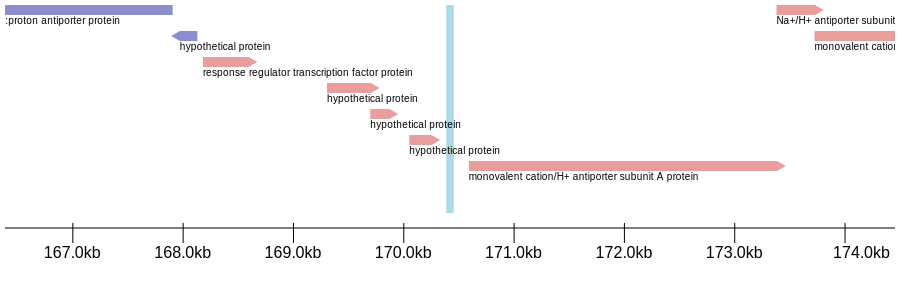

Match #115
E-value: 7.000000000000002e-06
%GC: 0.63
Score: 55.3
Genome Assembly: GCF_001976065.1_ASM197606v1
Target: NZ_MNAH01000008.1/253150-253228
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas putida group
Matched Sequence: UCCGGCUGGGUGCGUUGCUgcAUGCGGCACAGCGCAGGUUAAAGcucaaaCGUUGGUCGGGCCGCCAGCGGAGAGUCAA


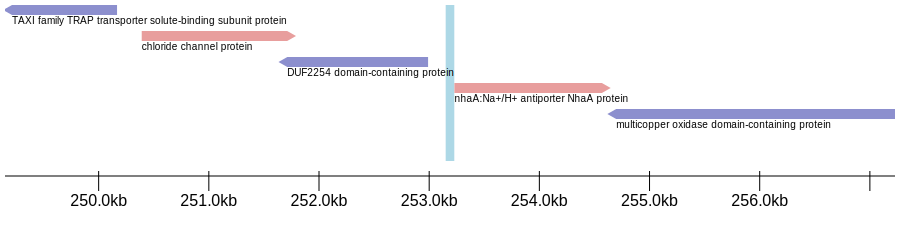

Match #116
E-value: 7.200000000000001e-06
%GC: 0.75
Score: 55.2
Genome Assembly: GCF_005503065.1_ASM550306v1
Target: NZ_SCOE01000010.1/104296-104364
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; unclassified Comamonadaceae
Matched Sequence: GCACGCUGGGUGUCCGGCGCUUCCUGCCGGGCAGGUUCAUGCGCAGGUCGGGCCGCCGCGCGGUUGGAC


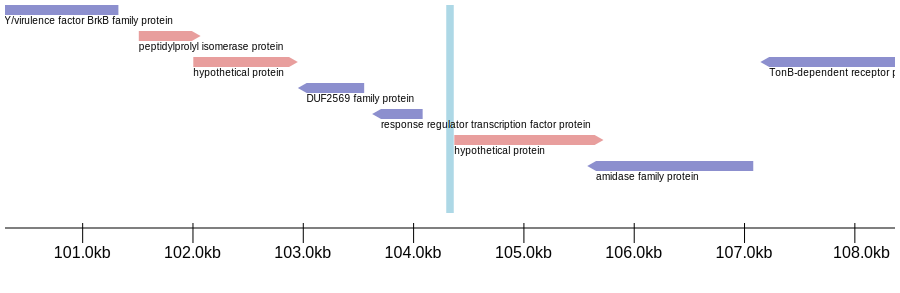

Match #121
E-value: 7.299999999999999e-06
%GC: 0.76
Score: 55.2
Genome Assembly: GCF_008329595.1_ASM832959v1
Target: NZ_NPKS01000022.1/33747-33818
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Rhizobiales; Methylobacteriaceae; Methylobacterium; unclassified Methylobacterium
Matched Sequence: CCCGGCAGGGUGCACGGUCcgucAAuCGGACCGGCAGGUCGAGCGCUGGUCGGGCCGCCAGCGCCGGAGACC


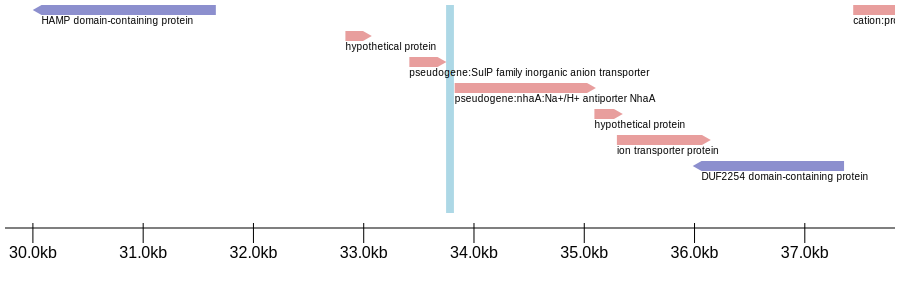

Match #122
E-value: 7.400000000000001e-06
%GC: 0.61
Score: 55.2
Genome Assembly: GCF_005502415.1_ASM550241v1
Target: NZ_SCOO01000054.1/13739-13817
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; unclassified Pseudomonas
Matched Sequence: UCCGGCUGGGUGCGUUGCUgcAUACGGCACAGCGCAGGUUAAAGcucaaaCGUUGGUCGGGCCGCCAGCGGAGAGUUAA


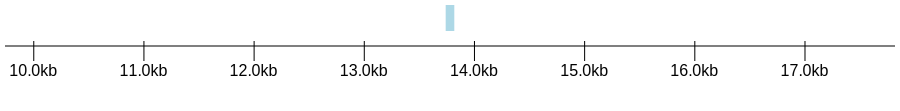

Match #125
E-value: 7.6e-06
%GC: 0.66
Score: 55.1
Genome Assembly: GCF_005406185.1_ASM540618v1
Target: NZ_RPFK01000008.1/666745-666820
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Sphingomonadales; Sphingomonadaceae; Sphingobium; unclassified Sphingobium
Matched Sequence: CGCGAGCGGGUGUUCGCUUgaGGGacUCAAGCGGGCAGGUUCACUugUGCUGGUCGGGCCGCCAGCACCGCUGAAU


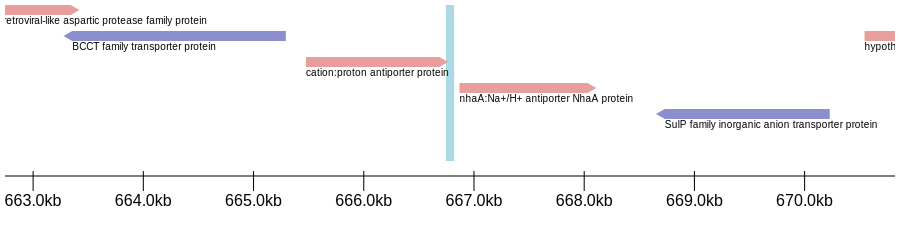

Match #126
E-value: 7.699999999999999e-06
%GC: 0.62
Score: 55.1
Genome Assembly: GCF_001421415.1_Leaf208
Target: NZ_LMKH01000008.1/5025-5092
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Sphingomonadales; Sphingomonadaceae; Sphingomonas; unclassified Sphingomonas
Matched Sequence: GCGAGACGGGUGUUCGUAUgGUGAUGCGGGCAGGUUUUACGUUGGUCGGGCCGCCAGCGUCGAAAUCC


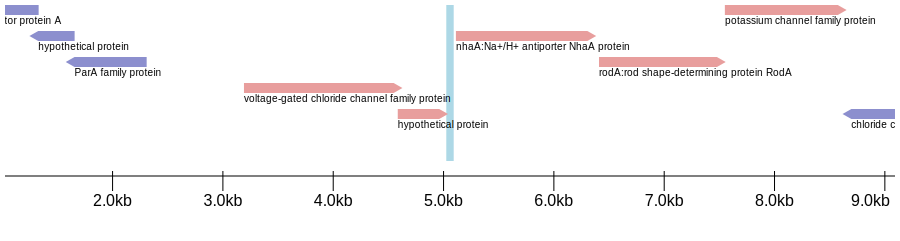

Match #128
E-value: 8e-06
%GC: 0.71
Score: 55.1
Genome Assembly: GCF_001425305.1_Root1290
Target: NZ_LMEE01000002.1/1002138-1002206
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Caulobacterales; Caulobacteraceae; Phenylobacterium; unclassified Phenylobacterium
Matched Sequence: AGGCGUCGGGUGCCCGGUCCUGUCGGCCGGUCAGGUUUAACGUUGGUCGGGCCGCCAGCGCGGAGAACC


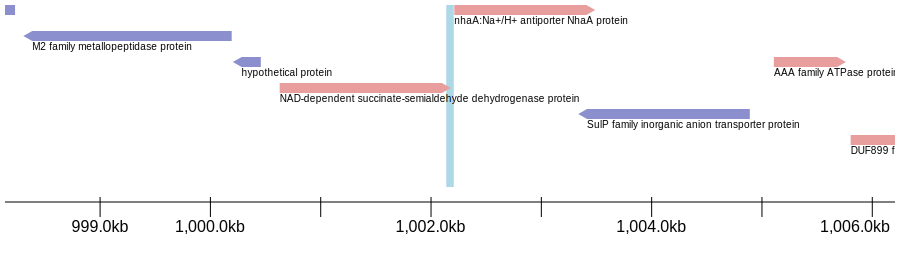

Match #136
E-value: 8.5e-06
%GC: 0.72
Score: 54.9
Genome Assembly: GCF_002197685.1_ASM219768v1
Target: NZ_NBBI01000001.1/444691-444762
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Sphingomonadales; Sphingomonadaceae; Sphingomonas
Matched Sequence: CCGCGGUGGGUGCCCGAUCccgCGUCUGAUUGGGCAGGUCGUGCGUUGGUCGGGCCGCCAGCGCUGGAGAAC


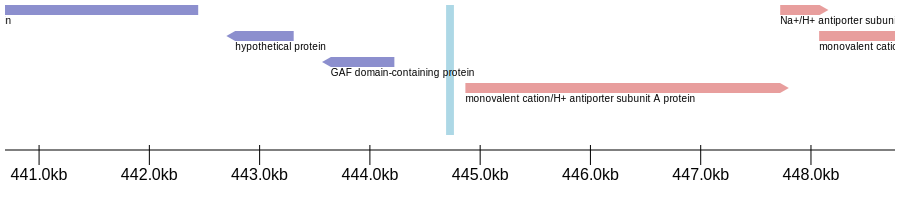

Match #139
E-value: 8.900000000000001e-06
%GC: 0.76
Score: 54.9
Genome Assembly: GCF_004801305.1_ASM480130v1
Target: NZ_SSOD01000020.1/82168-82241
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Rhodocyclales; Zoogloeaceae; Azoarcus; unclassified Azoarcus
Matched Sequence: UCCACGCGGGUGUCCGUCCgcaCUGGcGCGGGCGGGCAGGUUUUCGUGCCGGUCGGGCCGCCGCACGGCGAAUG


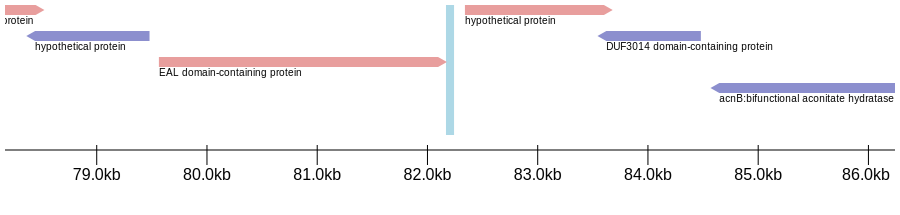

Match #141
E-value: 9.2e-06
%GC: 0.61
Score: 54.8
Genome Assembly: GCF_001952075.1_ASM195207v1
Target: NZ_LXYU01000002.1/320309-320377
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Rhizobiales; Bartonellaceae; Bartonella
Matched Sequence: UGCCAACGGGUGUUCGGGAaAUCGUUUCGGGCAGGUUUCAAGCUGGUCGGGCCGCCAGCACAGAAGGAC


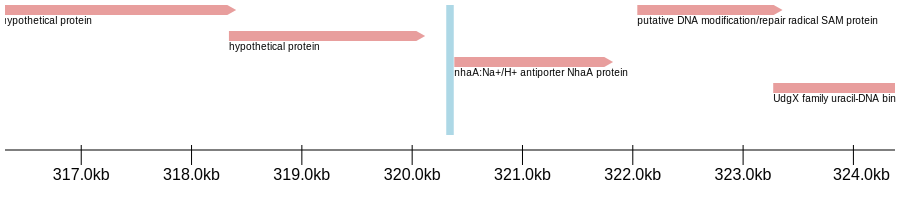

Match #142
E-value: 9.4e-06
%GC: 0.7
Score: 54.8
Genome Assembly: GCF_003984625.1_ASM398462v1
Target: NZ_RWKH01000012.1/167391-167463
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Variovorax; unclassified Variovorax
Matched Sequence: UGGCAUCGGGUGCGAGGCUgcuUuccaCGGCGUCGCAGGUUCAUGCGCUGGUCGGGCCGCCGCGCGGAUCAGU


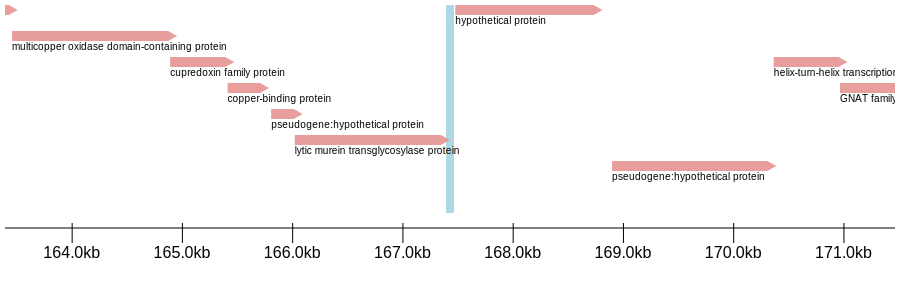

Match #143
E-value: 9.5e-06
%GC: 0.72
Score: 54.8
Genome Assembly: GCF_004216565.1_ASM421656v1
Target: NZ_SGWV01000007.1/519782-519853
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Burkholderiales genera incertae sedis; Leptothrix
Matched Sequence: GGUUUUUGGGUGCCCAGGCgCGGGaGCGUCGGGGCAGGUUGUCGCGAAGGUCGGGCCGCCUCGCGGACCUCA


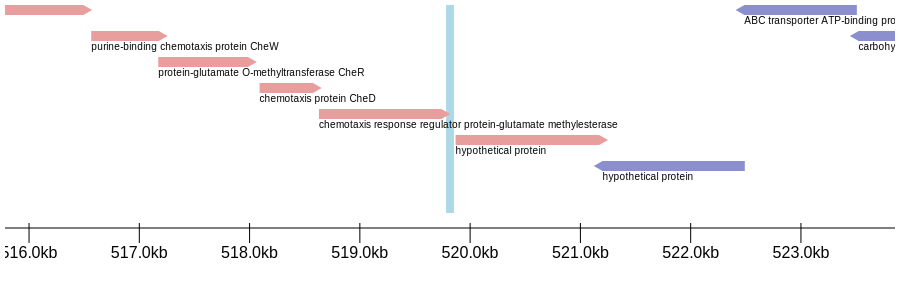

Match #144
E-value: 9.6e-06
%GC: 0.6
Score: 54.7
Genome Assembly: GCF_003287395.1_ASM328739v1
Target: NZ_PGFU01000009.1/19094-19165
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Sphingomonadales; Sphingomonadaceae; Sphingomonas
Matched Sequence: CCUGUGCGGGUGUUCGCAAAUAGUUGAUGCGGGCAGGUUCUAACGUUGGUCGGGCCGCCAACGGCGAACCUU


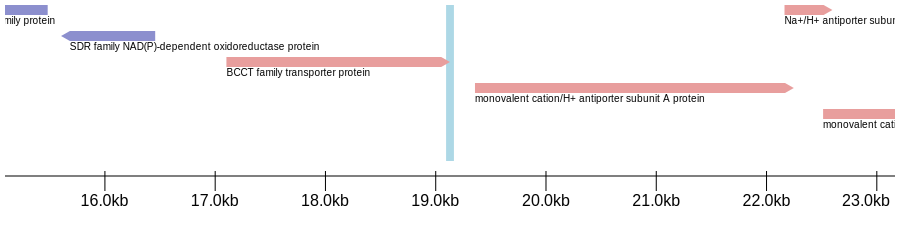

Match #145
E-value: 9.6e-06
%GC: 0.74
Score: 54.7
Genome Assembly: GCF_010020825.1_ASM1002082v1
Target: NZ_JAACJE010000001.1/2526863-2526932
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Acidovorax; unclassified Acidovorax
Matched Sequence: UCAGGCUGGGUGUACGCGCcgCAAGGGCGCGACAGGUUCAUGCGCUGGUCGGGCCGCCGCGCGGCUUGCC


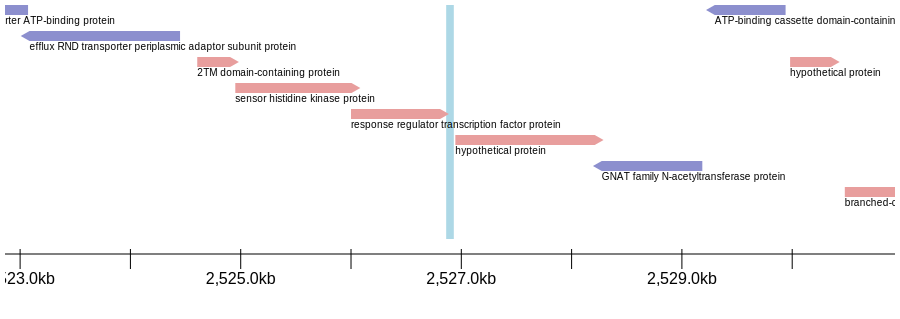

Match #147
E-value: 9.8e-06
%GC: 0.68
Score: 54.7
Genome Assembly: GCF_003854895.1_ASM385489v1
Target: NZ_CP033966.1/1459012-1459084
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Alcaligenaceae; Pigmentiphaga; unclassified Pigmentiphaga
Matched Sequence: UAACGCCGGGUGCUGCCGCuGUACAUGCGGCAGCAGGUUCUGGgCAUCGGUCGGGCCGCCGGUGCAGGAUUGC


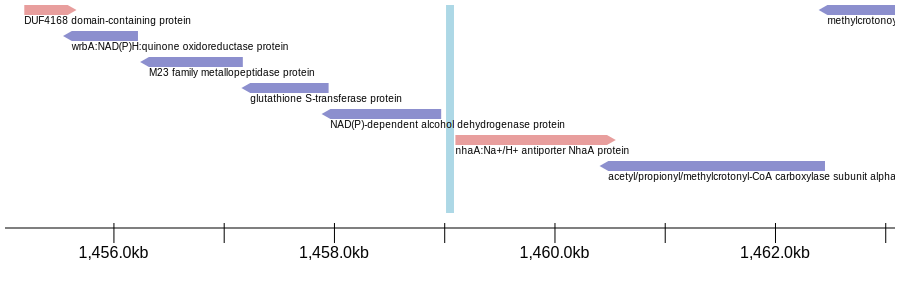

Match #149
E-value: 1e-05
%GC: 0.62
Score: 54.6
Genome Assembly: GCF_000312045.1_ASM31204v1
Target: NZ_HE978635.1/954556-954624
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Oxalobacteraceae; Noviherbaspirillum; Noviherbaspirillum massiliense
Matched Sequence: UCGACACGGGUGCUCAUAGUCCAAGUAUGAGCAGGUUCAUGCGACGGUCGGGCCGCCUCGCGGCUUCCU


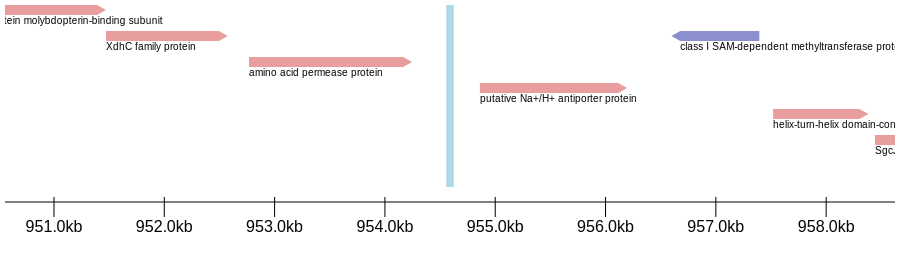

Match #151
E-value: 1e-05
%GC: 0.7
Score: 54.6
Genome Assembly: GCF_000015325.1_ASM1532v1
Target: NC_008752.1/4946563-4946629
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Acidovorax; Acidovorax citrulli
Matched Sequence: CGUGCCAGGGUGCCGUCACAUGGGGUGCGGCAGGUGUAGCGAAGGUCGGGCCGCCUCGCGGAUCACU


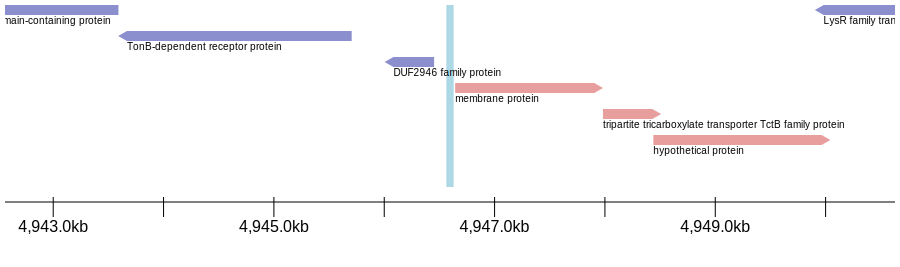

Match #165
E-value: 1.1e-05
%GC: 0.76
Score: 54.5
Genome Assembly: GCF_001425465.1_Leaf456
Target: NZ_LMQV01000020.1/6887-6957
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Rhizobiales; Methylobacteriaceae; Methylobacterium; unclassified Methylobacterium
Matched Sequence: CCCGCCUGGGUGCACGGUCcGGGUUGGACCGGCAGGGAACUGCGCUGGUCGGGCCGCCAGCGGCAGGAAGC


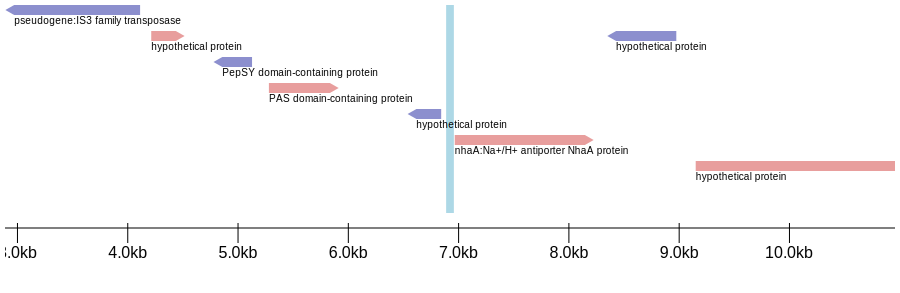

Match #167
E-value: 1.1e-05
%GC: 0.62
Score: 54.5
Genome Assembly: GCF_900102275.1_IMG-taxon_2651870108_annotated_assembly
Target: NZ_FNBI01000013.1/18835-18906
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Sphingomonadales; Sphingomonadaceae; Sphingomonas
Matched Sequence: CCUGUGCGGGUGUUCGCAAAUAGGUGAUGCGGGCAGGUUCUAACGUUGGUCGGGCCGCCAACGGCGAACCCU


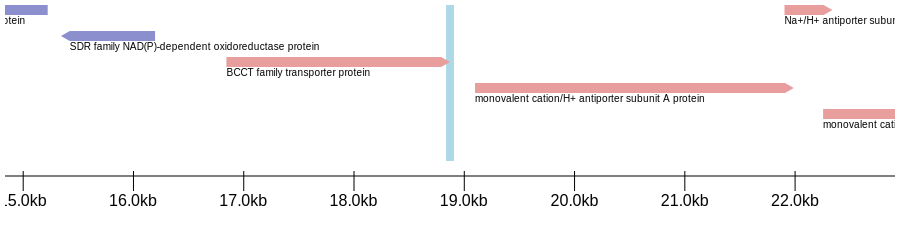

Match #168
E-value: 1.2e-05
%GC: 0.72
Score: 54.4
Genome Assembly: GCF_001463745.1_ASM146374v1
Target: NZ_BBWJ01000049.1/49391-49462
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Rhizobiales; Aurantimonadaceae; Aureimonas; unclassified Aureimonas
Matched Sequence: UGCGGGCGGGUGCGGAUCCAUCGUGGGUCGGCAGGUCAAUUcgCGCUGGUCGGGCCGCCAGCGACGGAGACC


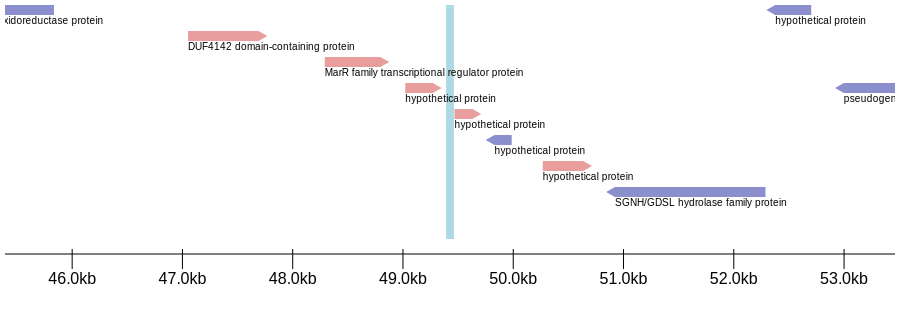

Match #183
E-value: 1.2e-05
%GC: 0.63
Score: 54.4
Genome Assembly: GCF_001592245.1_ASM159224v1
Target: NZ_BCWO01000009.1/136976-137050
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Burkholderiaceae; Cupriavidus; Cupriavidus oxalaticus
Matched Sequence: GCCGACAGGGUGUCUGCACugcacgucGCAGUGAGACAGGUUAAUGCGUUGGUCGGGCCGCCAACGCGAAUCCUC


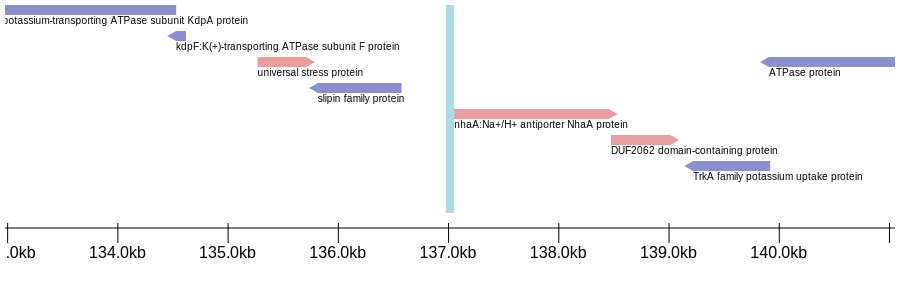

Match #187
E-value: 1.2e-05
%GC: 0.67
Score: 54.3
Genome Assembly: GCF_000176855.2_ASM17685v2
Target: NC_015138.1/4962498-4962564
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Acidovorax; Acidovorax avenae; Acidovorax avenae subsp. avenae
Matched Sequence: CCAGCCAGGGUGUCGUCACAUGGGGUGCGGCAGGUUUAGCGAAGGUCGGGCCGCCUCGCGGAUCACU


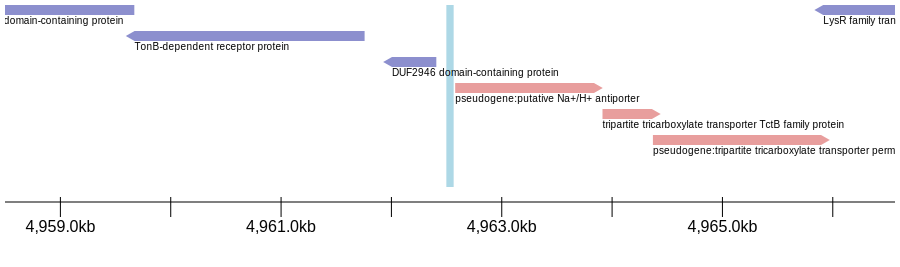

Match #190
E-value: 1.2e-05
%GC: 0.65
Score: 54.3
Genome Assembly: GCF_900078705.1_H050680373
Target: NZ_FKIF01000006.1/484-554
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Alcaligenaceae; Bordetella
Matched Sequence: AUGGGCUGGGUGUCUGCUGcAUUCUGCGGCAGGCAGGUUCAUGCGUCGGUCGGGCCGCCACGCGGAGUUUU


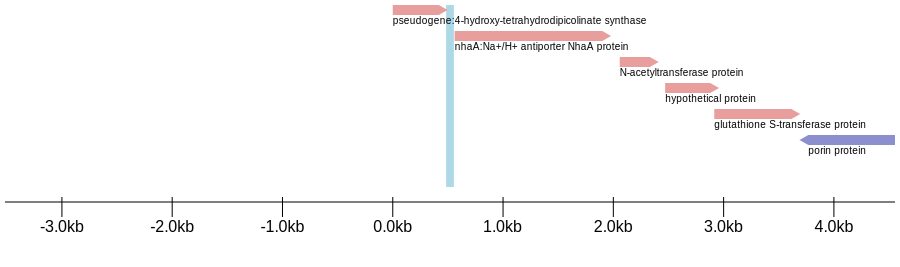

Match #194
E-value: 1.2e-05
%GC: 0.69
Score: 54.3
Genome Assembly: GCF_001017435.1_ASM101743v1
Target: NZ_CP011371.1/4195927-4196007
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Burkholderiales genera incertae sedis
Matched Sequence: UCGUUGCGGGUGUCGGGCGggacuugcuucuuguUGCCCCCGGCAGGUUGACGCGAUGGUCGGGCCGCCACGCGGGCUCAU


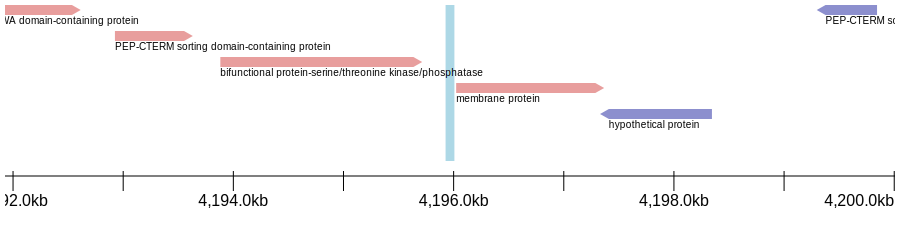

Match #195
E-value: 1.2e-05
%GC: 0.69
Score: 54.3
Genome Assembly: GCF_000518965.1_ASM51896v1
Target: NZ_KI912527.1/482275-482346
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Alcaligenaceae; Bordetella; Bordetella petrii
Matched Sequence: GGCGCCCGGGUGUCAGCCgcAUACUGCGGCGAGACAGGUUCAUGCGCAGGUCGGGCCGCCGCGCAAGGUAUA


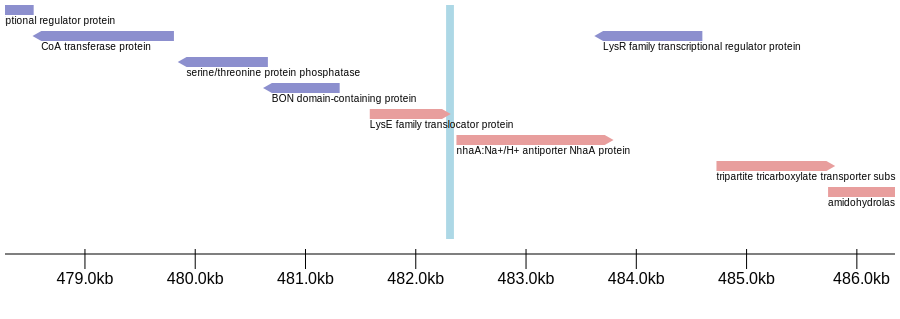

Match #202
E-value: 1.3e-05
%GC: 0.67
Score: 54.2
Genome Assembly: GCF_005405905.1_ASM540590v1
Target: NZ_BJHU01000009.1/180640-180709
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Acidovorax; unclassified Acidovorax
Matched Sequence: UGGACGCGGGUGUCGCAGUcAUGGUGAUUCGGCAGGUUCAUGCGCUGGUCGGGCCGCCGCGCGGCUUUUC


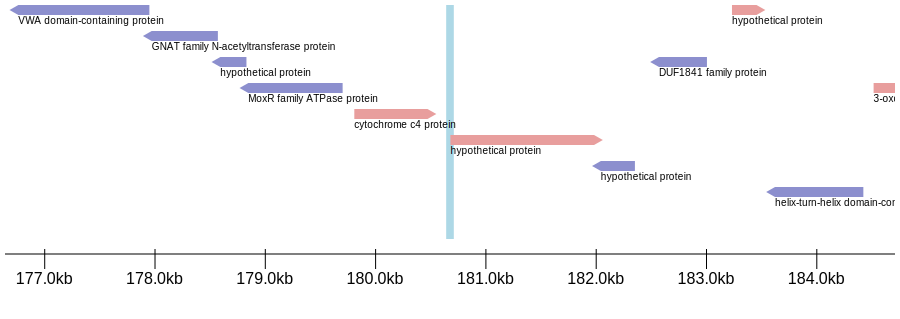

Match #216
E-value: 1.4e-05
%GC: 0.71
Score: 54.1
Genome Assembly: GCF_000213805.1_ASM21380v1
Target: NC_015556.1/1662407-1662481
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas putida group; Pseudomonas fulva
Matched Sequence: AGCGGCUGGGUGCCACCgcAGUuGCGGCAAGGCAGGUUCAUUcccgCGCUGGUCGGGCCGCCAGCGCAGAGCACA


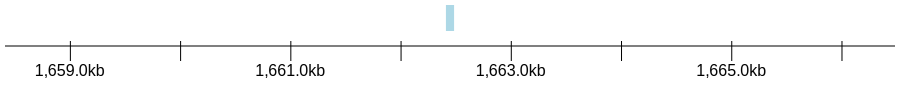

Match #219
E-value: 1.5e-05
%GC: 0.59
Score: 54.0
Genome Assembly: GCF_003851705.1_ASM385170v1
Target: NZ_CP027728.1/3585353-3585431
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; unclassified Pseudomonas
Matched Sequence: UCGCCCUGGGUGCGCUGCUgcAUACGGCACAGCGCAGGUUAAAGgauaagCGUUGGUCGGGCCGCCAAUGGAGAUUUGU


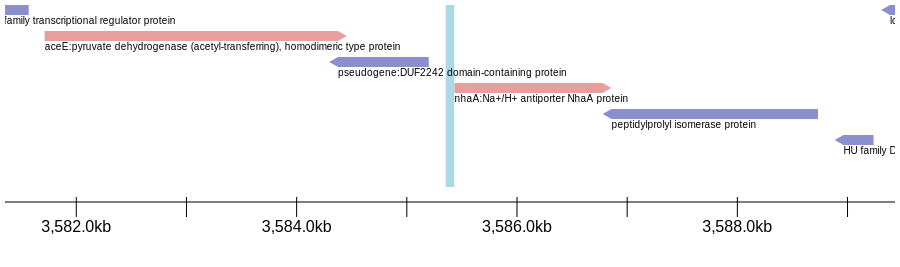

Match #223
E-value: 1.5e-05
%GC: 0.68
Score: 54.0
Genome Assembly: GCF_004216755.1_ASM421675v1
Target: NZ_SGWZ01000001.1/558106-558177
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Alcaligenaceae; Kerstersia
Matched Sequence: CGCAGCAGGGUGUUAGCCgcAUAUUGCGGCGAGACAGGUUCAUGCGCUGGUCGGGCCGCCGCGCGGAGCCAU


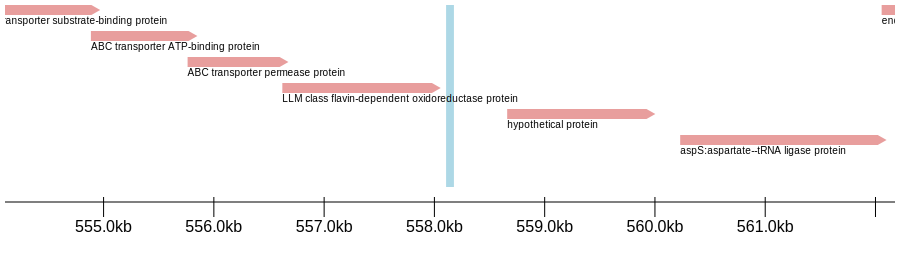

Match #225
E-value: 1.5e-05
%GC: 0.62
Score: 54.0
Genome Assembly: GCF_902498075.1_PS903
Target: NZ_CABVIS010000005.1/11894-11971
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas fluorescens group
Matched Sequence: UCCGGCUGGGUGCGUUGCUgcAUACGGCACAGCGCAGGUUAAACucaaaCGUUGGUCGGGCCGCCAGCGGAGAGUCAA


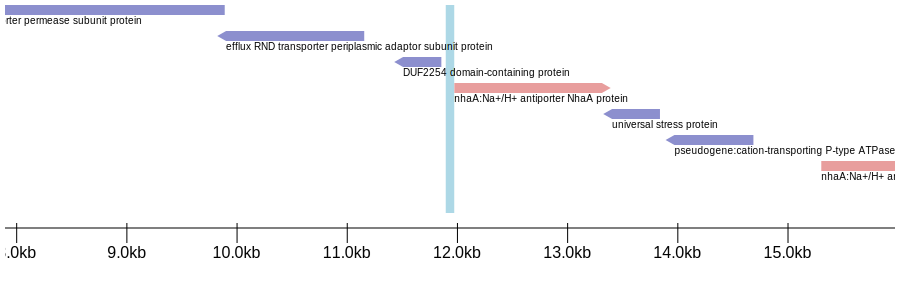

Match #226
E-value: 1.5e-05
%GC: 0.67
Score: 54.0
Genome Assembly: GCF_001476895.1_ASM147689v1
Target: NZ_LDTB01000080.1/8105-8176
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Sphingomonadales; Sphingomonadaceae; Sphingomonas
Matched Sequence: CGACCUUGGGUGCUCGCCGaUCGCuGGUGCGGGCAGGUUCUAACGUUGGUCGGGCCGCCAACGUGGAACCGU


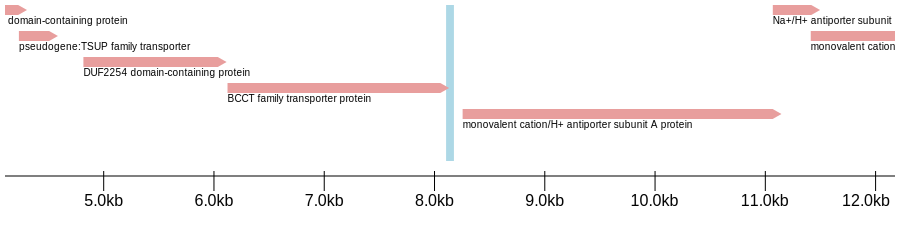

Match #227
E-value: 1.5e-05
%GC: 0.7
Score: 53.9
Genome Assembly: GCF_005952805.1_ASM595280v1
Target: NZ_CP040709.1/3963286-3963351
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Burkholderiales genera incertae sedis; Inhella
Matched Sequence: CUGCGCCGGGUGUUGCCCUUCAGGGCAACAGGUUCACGCGCUGGUCGGGCCGCCACGCGGAUCUUG


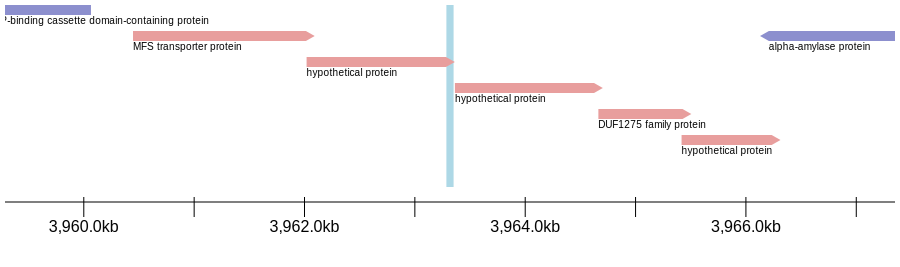

Match #231
E-value: 1.6e-05
%GC: 0.6
Score: 53.8
Genome Assembly: GCF_000009285.1_ASM928v2
Target: NC_008314.1/496826-496900
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Burkholderiaceae; Cupriavidus; Cupriavidus necator
Matched Sequence: GCCGAUAGGGUGUCUACgcugcacgucGCAGUGAGACAGGUUAAUGCGUUGGUCGGGCCGCCAACGCAAAUGCUC


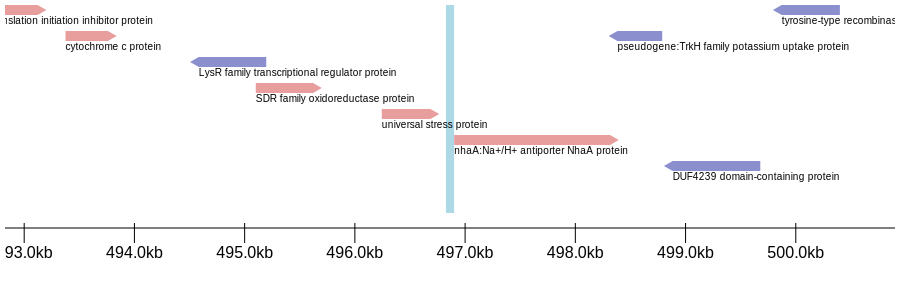

Match #238
E-value: 1.6e-05
%GC: 0.65
Score: 53.8
Genome Assembly: GCF_001424835.1_Root318D1
Target: NZ_LMCQ01000012.1/722541-722620
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Variovorax; unclassified Variovorax
Matched Sequence: UGGGACCGGGUGCGGAGCCgcuugUuuuuucaaGUGGUCUCGCAGGUUCAUGCGAUGGUCGGGCCGCCUCGCGGACCUGC


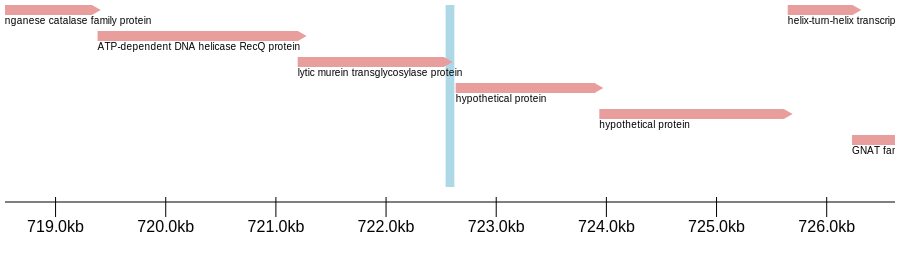

Match #259
E-value: 1.7e-05
%GC: 0.69
Score: 53.8
Genome Assembly: GCF_008369125.1_ASM836912v1
Target: NZ_VOAY01000002.1/677752-677825
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Alcaligenaceae; Pusillimonas; unclassified Pusillimonas
Matched Sequence: UCGCCCCGGGUGUUAGGGCugcAUGUUgCGGCUCGGCAGGUUAAAGCGUAGGUCGGGCCGCCGCGCGGAGACAC


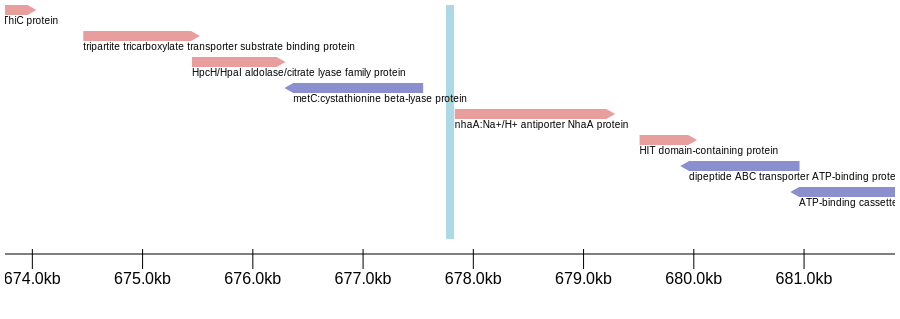

Match #261
E-value: 1.7e-05
%GC: 0.67
Score: 53.8
Genome Assembly: GCF_002310295.2_ASM231029v2
Target: NZ_CP023313.2/473158-473226
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Caulobacterales; Caulobacteraceae; Caulobacter
Matched Sequence: CGGGCUUGGGUGGUCGAUCGUCUUGGUCGAUCAGGGUUUACGUUGGUCGGGCCGCCAGCGCGGAGACCC


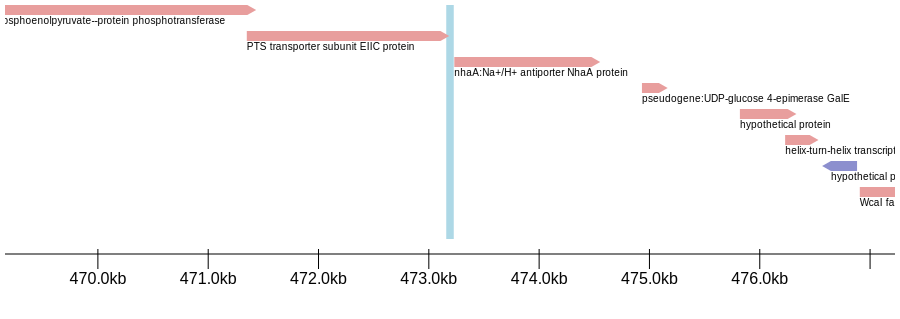

Match #265
E-value: 1.7e-05
%GC: 0.76
Score: 53.7
Genome Assembly: GCF_000382705.1_ASM38270v1
Target: NZ_ARQE01000001.1/202815-202885
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Rhizobiales; Aurantimonadaceae; Aureimonas; Aureimonas ureilytica
Matched Sequence: CCGGGGUGGGUGCAGGUCCAUCGGGGGCCGGCAGGUCAUUCgCGCUGGUCGGGCCGCCAGCGAGGGAGACC


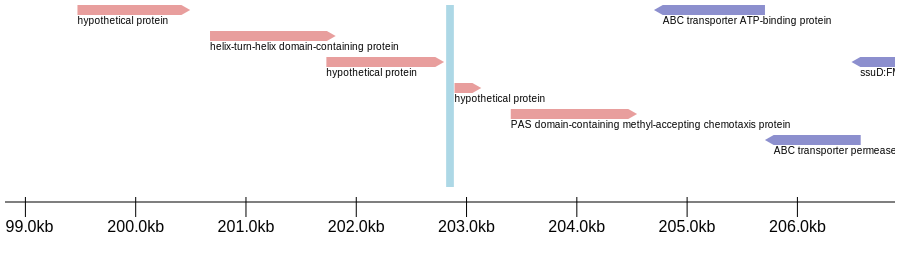

Match #267
E-value: 1.8e-05
%GC: 0.59
Score: 53.7
Genome Assembly: GCF_003852065.1_ASM385206v1
Target: NZ_CP027729.1/3598166-3598244
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; unclassified Pseudomonas
Matched Sequence: UCGCGCUGGGUGCGCUGCUgcAUACGGCACAGCGCAGGUUAAAGgauaagCGUUGGUCGGGCCGCCAAUGGAGAUUUGU


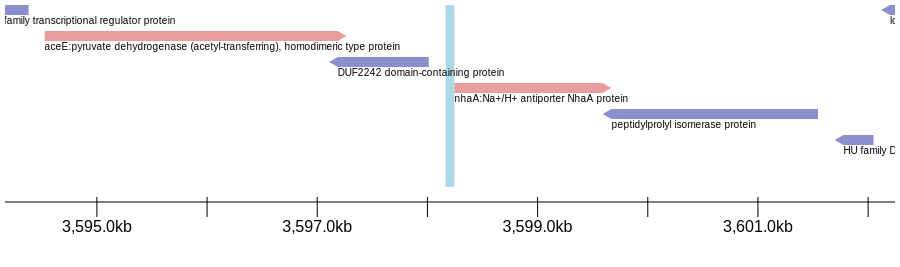

Match #268
E-value: 1.8e-05
%GC: 0.77
Score: 53.6
Genome Assembly: GCF_007677875.1_ASM767787v1
Target: NZ_VEDO01000025.1/19688-19757
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Variovorax
Matched Sequence: CCGCCCCGGGUGGCAUGCCgcAUCGGGCAUGCCAGGUCUUCGCGCAGGUCGGGCCGCCGCGCGGUCUACC


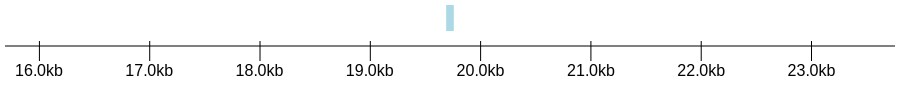

Match #269
E-value: 1.8e-05
%GC: 0.63
Score: 53.6
Genome Assembly: GCF_001400635.1_PprICMP3956
Target: NZ_LJRC01000041.1/18381-18459
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas syringae group; Pseudomonas syringae group genomosp. 3
Matched Sequence: UCGCCGCGGGUGUAUCGACgcAUGUCGCGCGGUGCAGGUUAAAAgugacgCGUUGGUCGGGCCGCCAACGGAGAGUCAU


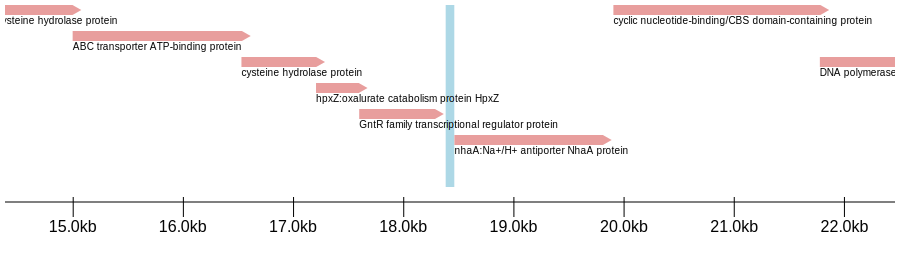

Match #272
E-value: 1.8e-05
%GC: 0.65
Score: 53.6
Genome Assembly: GCF_003094595.1_ASM309459v1
Target: NZ_QDKP01000063.1/18817-18885
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Caulobacterales; Caulobacteraceae; Caulobacter
Matched Sequence: CAGGGCCGGGUGGUCAGCUGUUUUGGUUGAUCAGGGUUUACGUUGGUCGGGCCGCCAGCGCGGAGACCC


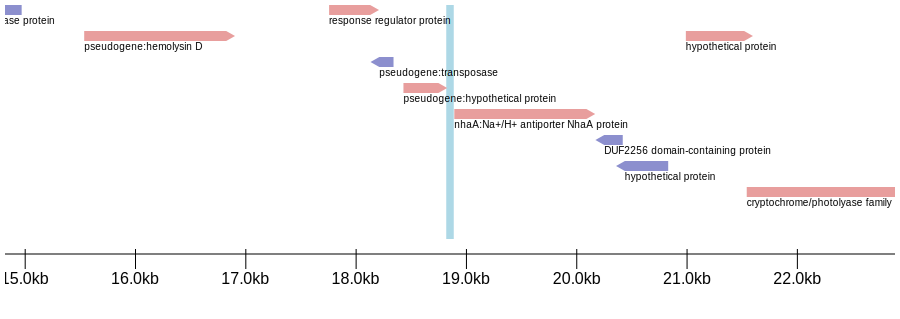

Match #274
E-value: 1.9e-05
%GC: 0.59
Score: 53.6
Genome Assembly: GCF_001952855.1_ASM195285v1
Target: NZ_LPNO01000006.1/141016-141094
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; unclassified Pseudomonas
Matched Sequence: UCGCCCUGGGUGCGCUGCUgcAUACGGCACAGCGCAGGUUAAAGgauaagCAUUGGUCGGGCCGCCAAUGGAGACUUGU


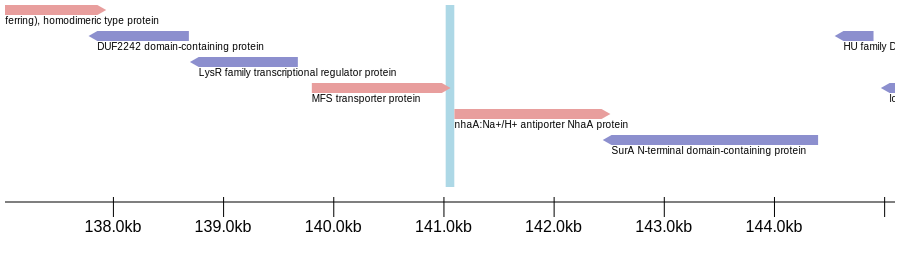

Match #275
E-value: 1.9e-05
%GC: 0.57
Score: 53.6
Genome Assembly: GCF_902498165.1_PS906
Target: NZ_CABVIW010000002.1/542179-542255
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas fluorescens group
Matched Sequence: UCACAGCGGGUGUCCUGCUguAUuacGCGCAGGGCAGGUUAAUCguaaCGUUGGUCGGGCCGCCAUCGGAGAAUUUC


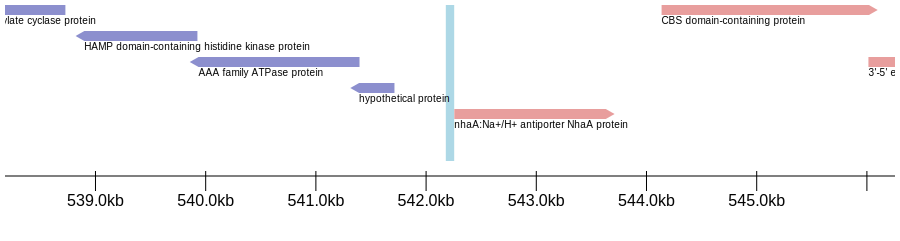

Match #277
E-value: 1.9e-05
%GC: 0.69
Score: 53.5
Genome Assembly: GCF_001411535.1_ASM141153v1
Target: NZ_LHUP01000159.1/797-866
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Acidovorax; unclassified Acidovorax
Matched Sequence: GGAAGUUGGGUGUCGGCGCcAUGGUGGCCCGGCAGGUUCAUGCGCUGGUCGGGCCGCCACGCGGUUUUUC


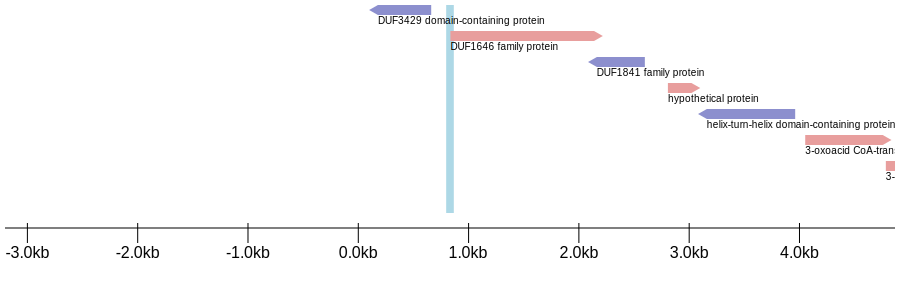

Match #278
E-value: 2e-05
%GC: 0.69
Score: 53.5
Genome Assembly: GCF_001429395.1_Root381
Target: NZ_LMJT01000034.1/253885-253955
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Rhizobiales; Bradyrhizobiaceae; Bosea; unclassified Bosea
Matched Sequence: GCCGGCAGGGUGUUCCGCUcgAUUGUGGGUGGGCAGGUUAAGCGCAGGUCGGGCCGCCAGCGCGGAGAAUC


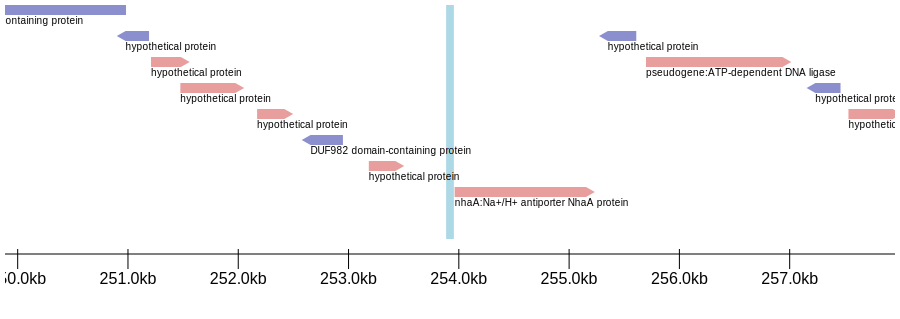

Match #284
E-value: 2.1e-05
%GC: 0.75
Score: 53.4
Genome Assembly: GCF_004363955.1_ASM436395v1
Target: NZ_SNZR01000004.1/1667-1735
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Rhizobiales; Methylobacteriaceae; Enterovirga
Matched Sequence: CGUCCUCGGGUGUUCGCCAGUUGGGGCGGGCAGGUUUCAGCGCUGGUCGGGCCGCCGGCGCCGGAGACC


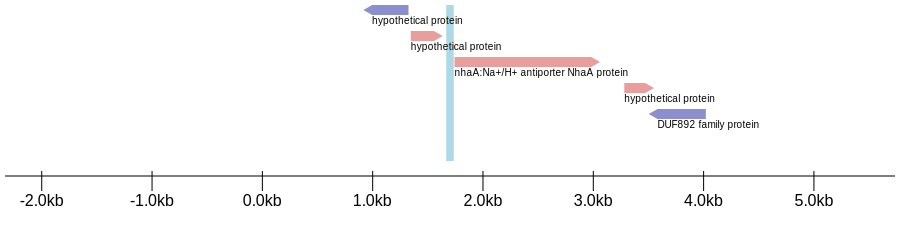

Match #285
E-value: 2.1e-05
%GC: 0.57
Score: 53.4
Genome Assembly: GCF_001428545.1_Root189
Target: NZ_LMHZ01000056.1/234923-234990
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Oxalobacteraceae; Noviherbaspirillum; unclassified Noviherbaspirillum
Matched Sequence: UUUUUAAGGGUGCUCACACaAUUACGUGUGGCAGGUUGUGCGACGGUCGGGCCGCCUCGCGGCUUUUC


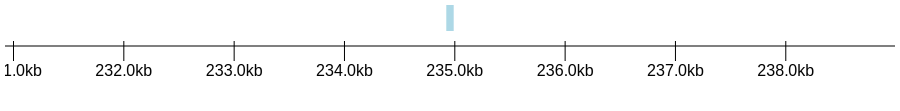

Match #286
E-value: 2.1e-05
%GC: 0.67
Score: 53.4
Genome Assembly: GCF_000006905.1_ASM690v1
Target: NC_002696.2/471468-471536
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Caulobacterales; Caulobacteraceae; Caulobacter; Caulobacter vibrioides
Matched Sequence: GGGGCUUGGGUGGUCGAUCGUCUUGGUCGAUCAGGGUUUACGUUGGUCGGGCCGCCAGCGCGGAGACCC


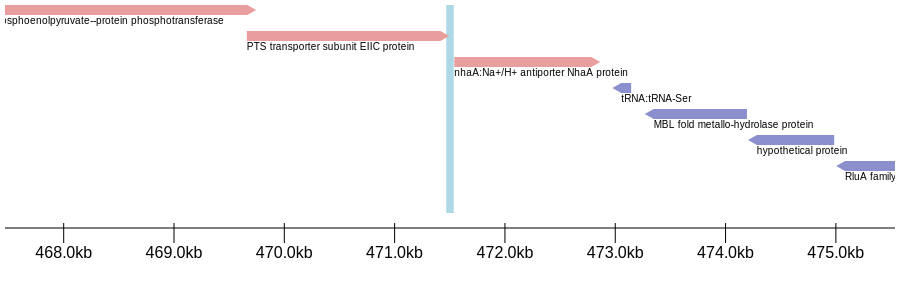

Match #291
E-value: 2.1e-05
%GC: 0.59
Score: 53.3
Genome Assembly: GCF_000026125.1_ASM2612v1
Target: NC_009138.1/2454962-2455034
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Oxalobacteraceae; Herminiimonas
Matched Sequence: UCAGUACGGGUGUAGCGUUgcAUCGUGCAGCGAGACAGGUUUAUGCGAUGGUCGGGCCGCCACGCGGGAUUAU


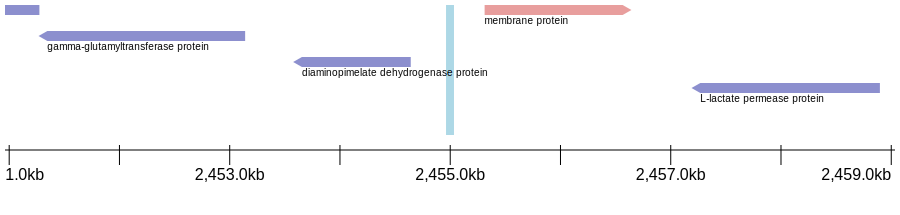

Match #293
E-value: 2.2e-05
%GC: 0.69
Score: 53.3
Genome Assembly: GCF_006716905.1_ASM671690v1
Target: NZ_VFPV01000003.1/594750-594817
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Acidovorax
Matched Sequence: GCGCGCCGGGUGUCUGCGCaaAUCGGCGCAACAGGUACAGCGAUGGUCGGGCCGCCACGCGGCUUUUC


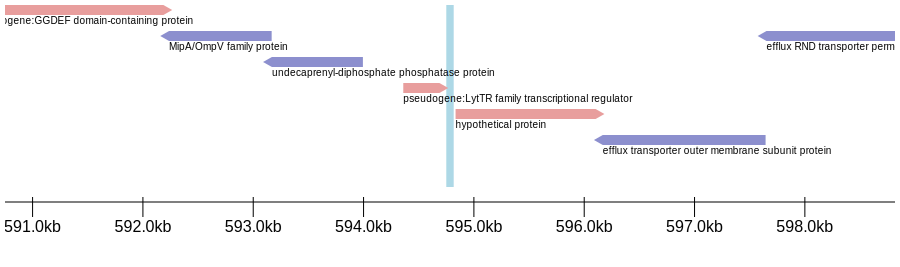

Match #294
E-value: 2.2e-05
%GC: 0.77
Score: 53.3
Genome Assembly: GCF_003671765.1_ASM367176v1
Target: NZ_QPIB01000012.1/512117-512186
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Xenophilus; unclassified Xenophilus
Matched Sequence: GCGCGCUGGGUGUCCGGCUgCUUCCUGCCGGGCAGGUUCAUGCGCAGGUCGGGCCGCCGCGCGGCUGGAC


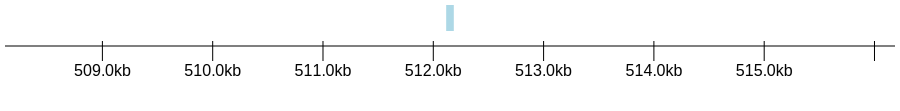

Match #296
E-value: 2.3e-05
%GC: 0.68
Score: 53.2
Genome Assembly: GCF_000622225.1_ASM62222v1
Target: NZ_JHWD01000028.1/42000-42073
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Rhodospirillales; Acetobacteraceae; Roseomonas; Roseomonas mucosa
Matched Sequence: AACGCCCGGGUGUUCGCUCcagAUACUGAGUGGGCAGGGUUUCAgCGUUGGUCGGGCCGCCAGCGGCGCAGACC


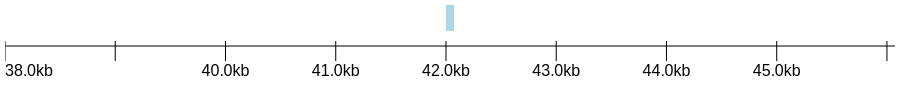

Match #305
E-value: 2.3e-05
%GC: 0.75
Score: 53.2
Genome Assembly: GCF_902506565.1_VARIO8X_assembly
Target: NZ_LR732703.1/1000089-1000157
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; unclassified Burkholderiales
Matched Sequence: CGCUCAAGGGUGGGGCGCCgAUCCGGGCGUCCCAGGUGUUGCGAAGGUCGGGCCGCCUCGCGGCUCCUC


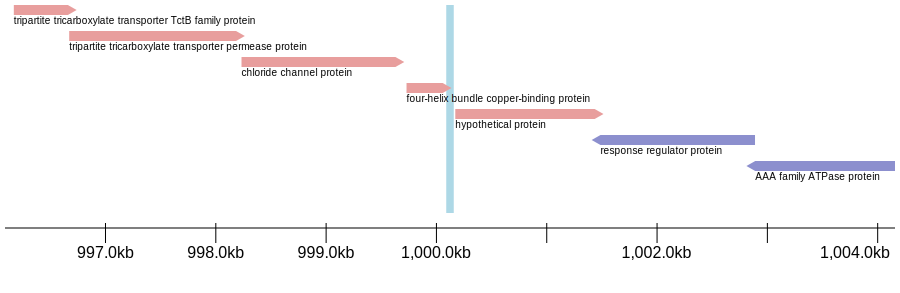

Match #306
E-value: 2.4e-05
%GC: 0.59
Score: 53.2
Genome Assembly: GCF_003851745.1_ASM385174v1
Target: NZ_CP027730.1/3703030-3703108
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; unclassified Pseudomonas
Matched Sequence: UCGCCCUGGGUGCGCUGCUgcAUAUGGCACAGCGCAGGUUAAAGgauaagCGUUGGUCGGGCCGCCAAUGGAGAUCUGU


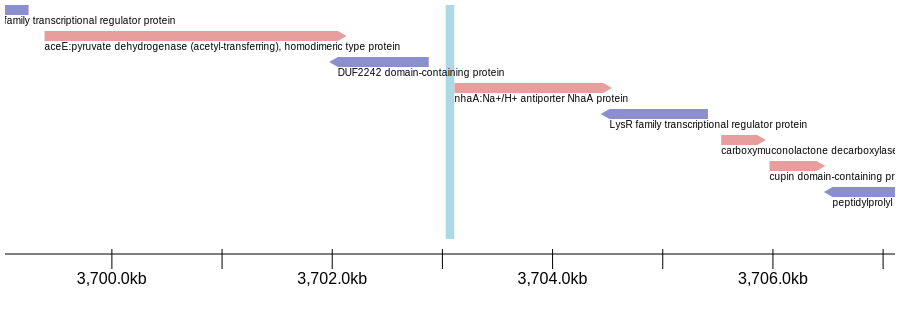

Match #314
E-value: 2.5e-05
%GC: 0.63
Score: 53.1
Genome Assembly: GCF_006094435.1_ASM609443v1
Target: NZ_CP034783.1/3044929-3045006
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; unclassified Pseudomonas
Matched Sequence: UCCGGCUGGGUGCGUUGCGgcAUACGGCACAGCGCAGGUUAAACucaaaCGUUGGUCGGGCCGCCAGCGGAGAGUCAA


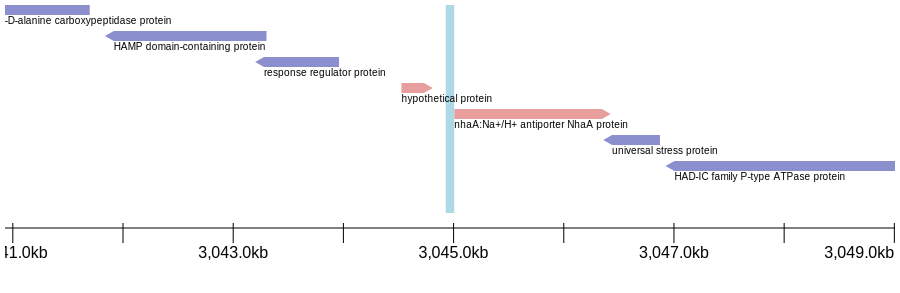

Match #315
E-value: 2.5e-05
%GC: 0.69
Score: 53.1
Genome Assembly: GCF_001428665.1_Root219
Target: NZ_LMIJ01000008.1/206439-206508
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Acidovorax; unclassified Acidovorax
Matched Sequence: CAGGACCGGGUGUACACGCcACAAGGGCGUGACAGGUUCAUGCGUCGGUCGGGCCGCCACGCGGCUUCAC


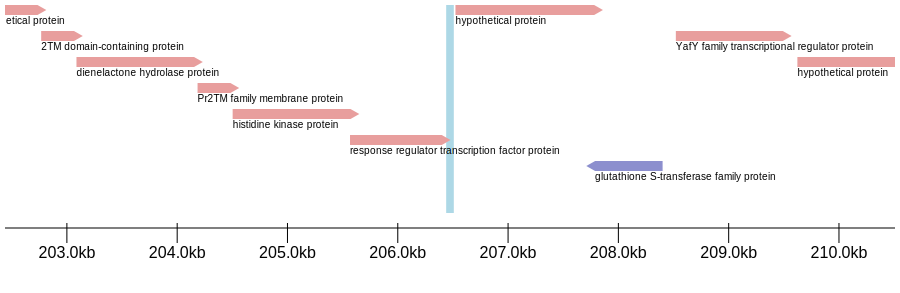

Match #316
E-value: 2.6e-05
%GC: 0.67
Score: 53.0
Genome Assembly: GCF_001476495.1_ASM147649v1
Target: NZ_LDTD01000088.1/151-219
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Sphingomonadales; Sphingomonadaceae; Sphingomonas
Matched Sequence: CGCCCCAGGGUGUUCGUGGAUCAGGCACGGGCAGGAUGAUCGUUGGUCGGGCCGCCAGCGACGAUGAAC


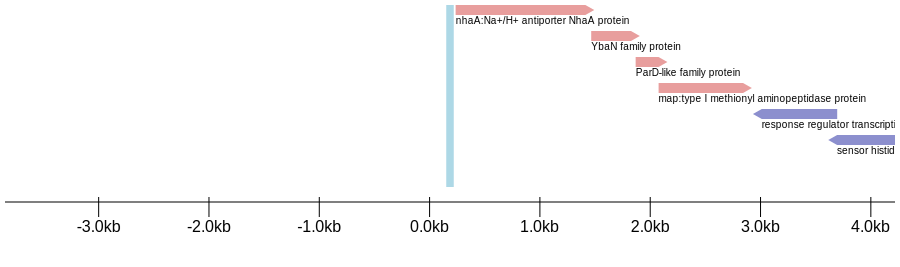

Match #317
E-value: 2.6e-05
%GC: 0.66
Score: 53.0
Genome Assembly: GCF_009360345.1_ASM936034v1
Target: NZ_SPDP01000001.1/1655424-1655496
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Alcaligenaceae; unclassified Alcaligenaceae
Matched Sequence: UAACGCCGGGUGUUCCCGCuguAUAUGCGGGAGCAGGUUCUGGgCAUCGGUCGGGCCGCCGGUGCAGGAUUGC


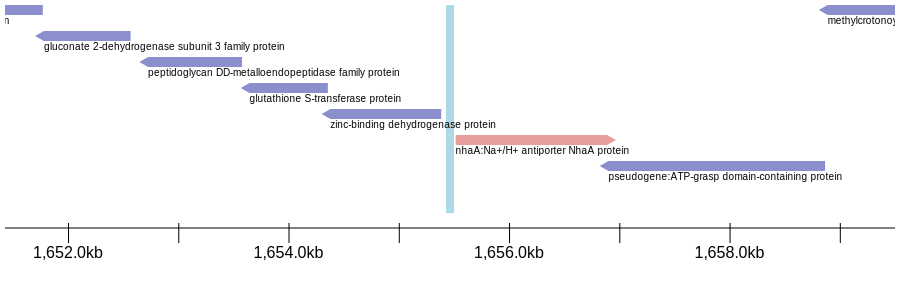

Match #320
E-value: 2.6e-05
%GC: 0.59
Score: 53.0
Genome Assembly: GCF_003851685.1_ASM385168v1
Target: NZ_CP027727.1/3694329-3694407
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; unclassified Pseudomonas
Matched Sequence: UCGCCCUGGGUGCGCUGCUgcAUACGGCACAGCGCAGGUUAAAGaauaagCGUUGGUCGGGCCGCCAAUGGAGAUAGGU


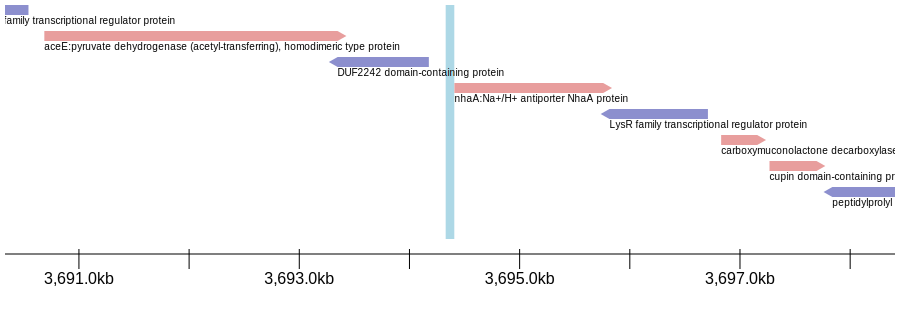

Match #324
E-value: 2.7e-05
%GC: 0.7
Score: 52.9
Genome Assembly: GCF_000333675.2_Pseudacidovorax_intermedius_NH-1
Target: NZ_ANOY02000377.1/748-818
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Pseudacidovorax; Pseudacidovorax intermedius
Matched Sequence: UAGGCUUGGGUGCGAGGCGcagAUGGGCGCCACGCAGGAGUCGCGAAGGUCGGGCCGCCUCGCGGAUUGCU


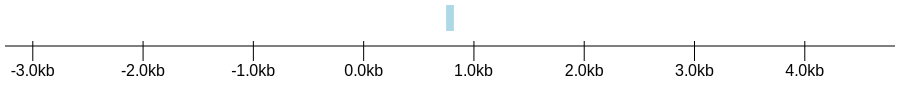

Match #328
E-value: 2.8000000000000006e-05
%GC: 0.7
Score: 52.9
Genome Assembly: GCF_001428645.1_Root217
Target: NZ_LMIH01000010.1/34899-34968
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Acidovorax; unclassified Acidovorax
Matched Sequence: CAGGGCCGGGUGUACACGCcACAAGGGCGUGACAGGUUCAUGCGUCGGUCGGGCCGCCACGCGGCUUCAC


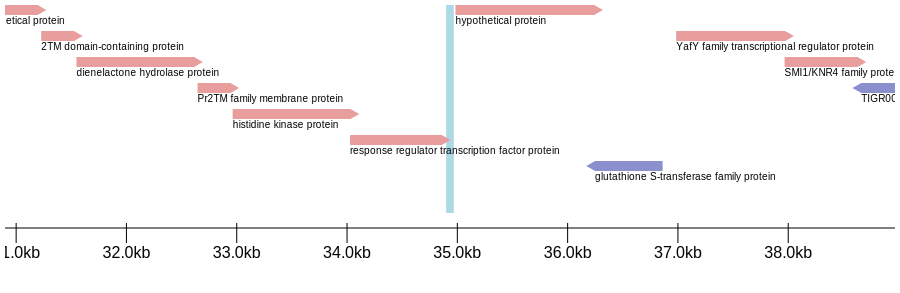

Match #331
E-value: 2.9e-05
%GC: 0.68
Score: 52.8
Genome Assembly: GCF_000250595.1_ASM25059v1
Target: NZ_JH604575.1/247275-247350
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas chlororaphis group; Pseudomonas fragi
Matched Sequence: CGGCGCUGGGUGCCACCgcaACaacGCGGCAGGGCAGGUUAAUUuagCGAAGGUCGGGCCGCCAUCGCGGAGUCGC


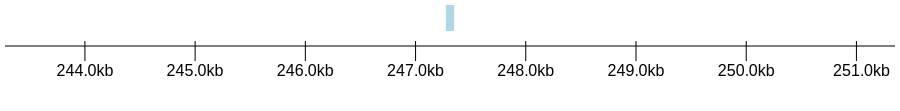

Match #340
E-value: 2.9e-05
%GC: 0.71
Score: 52.8
Genome Assembly: GCF_900113065.1_IMG-taxon_2654587881_annotated_assembly
Target: NZ_FOOA01000002.1/105235-105306
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Rhizobiales; Aurantimonadaceae; Aurantimonas
Matched Sequence: CCCGUCCGGGUGCGCGUCCGUACCGGAGGCGCAGGUGUACUcaCGUUGGUCGGGCCGCCAGCGAUGAGAACC


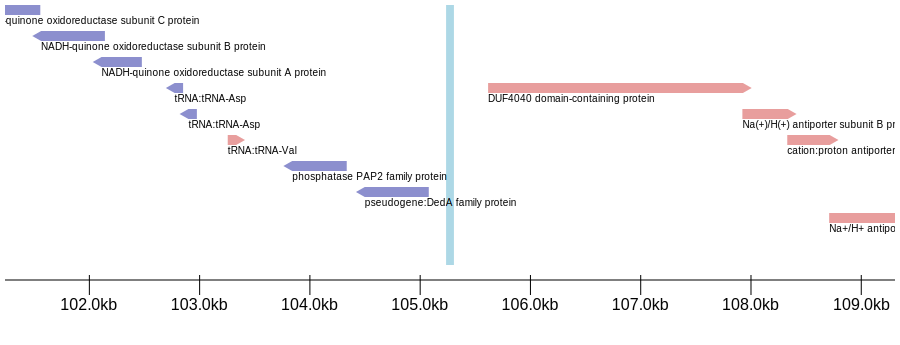

Match #341
E-value: 2.9e-05
%GC: 0.63
Score: 52.8
Genome Assembly: GCF_000293885.2_ASM29388v3
Target: NZ_CP010945.1/3704209-3704286
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas fluorescens group; Pseudomonas fluorescens
Matched Sequence: UCCGGCUGGGUGCGUUGCUgcAUACGGCACGGCGCAGGUUAAGCucaaaCGUUGGUCGGGCCGCCAGCGGAGAGUUAA


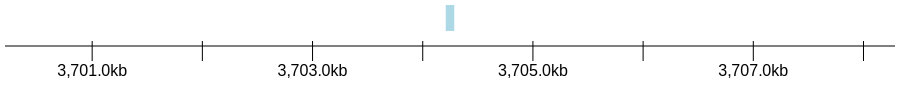

Match #343
E-value: 2.9e-05
%GC: 0.64
Score: 52.8
Genome Assembly: GCF_000015505.1_ASM1550v1
Target: NC_008781.1/3149348-3149421
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Polaromonas; Polaromonas naphthalenivorans
Matched Sequence: UAGGAAUGGGUGUCGUCaucgcAUgcaGCGGUGCGGCAGGUUCAUGCGAUGGUCGGGCCGCCUCGCGGACUAAC


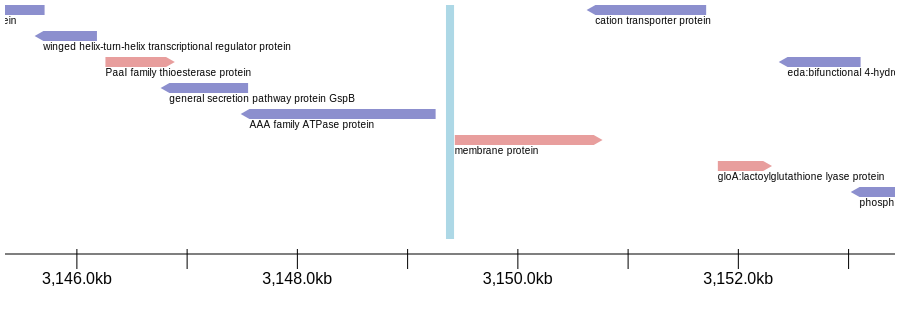

Match #344
E-value: 3e-05
%GC: 0.75
Score: 52.7
Genome Assembly: GCF_000410615.1_ASM41061v1
Target: NZ_KE148446.1/12452-12527
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Sphingomonadales; Sphingomonadaceae; Novosphingobium; unclassified Novosphingobium
Matched Sequence: GGGGGGCGGGUGCUCGCUGgccagaacguGGUGCGGGCAGGCUUUUGCGCUGGUCGGGCCGCCAGCGGGCCAACAG


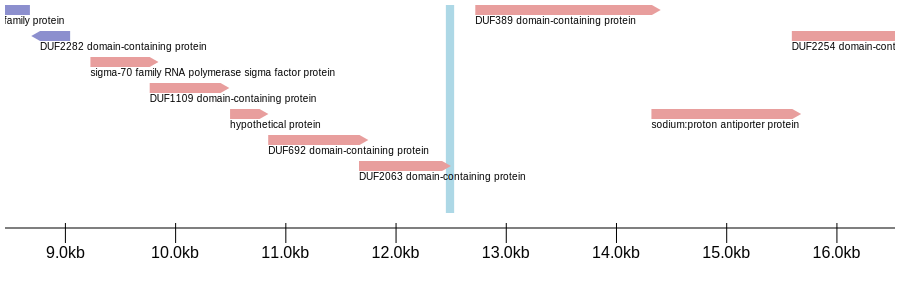

Match #346
E-value: 3.1e-05
%GC: 0.59
Score: 52.7
Genome Assembly: GCF_000263675.1_ASM26367v2
Target: NZ_CM001513.1/3805584-3805662
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas
Matched Sequence: CGCCCCUGGGUGCGCUGCUgcAUAAAGCACGGCGCAGGUUAAAAgccaagCAUUGGUCGGGCCGCCAAUGGAGAUUUGU


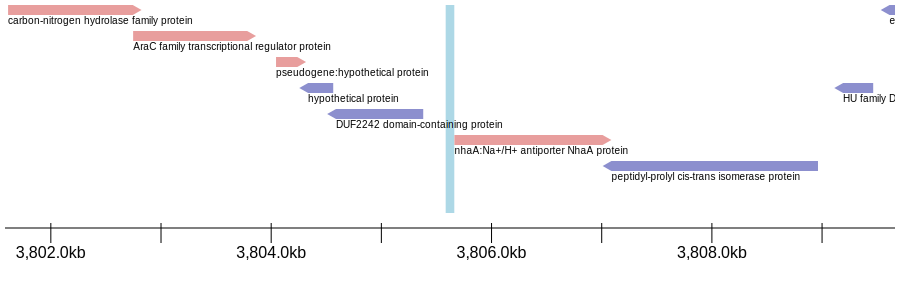

Match #350
E-value: 3.1e-05
%GC: 0.79
Score: 52.7
Genome Assembly: GCF_902141845.1_CECT_9862
Target: NZ_CABFPH010000042.1/8300-8370
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Rhizobiales; Methylobacteriaceae; Methylobacterium; unclassified Methylobacterium
Matched Sequence: CCGCCCCGGGUGCGCGGCCcGUGUCGGGUCGGCAGGUCUUUGCGUUGGUCGGGCCGCCAGCGGCGGAGACC


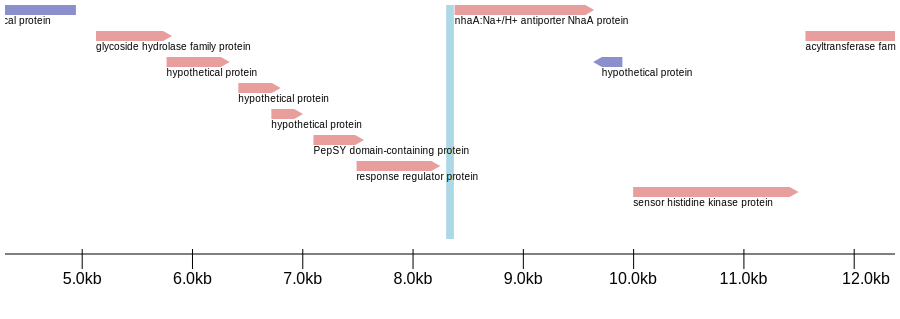

Match #352
E-value: 3.1e-05
%GC: 0.71
Score: 52.7
Genome Assembly: GCF_000333255.1_ASM33325v1
Target: NZ_BACT01000492.1/10553-10625
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Rhizobiales; Methylobacteriaceae; Methylobacterium; unclassified Methylobacterium
Matched Sequence: CCGACCCGGGUGCAUGAUCcgAAGGUCGGAUCGGCAGGCUUCAGCGUUGGUCGGGCCGCCAGCGGCGGAAGGC


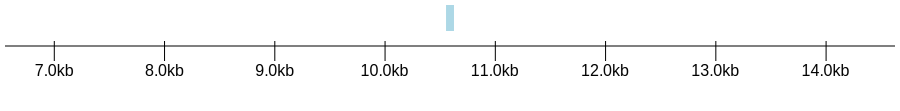

Match #357
E-value: 3.1e-05
%GC: 0.61
Score: 52.7
Genome Assembly: GCF_002849615.1_ASM284961v1
Target: NZ_PDNV01000003.1/147824-147890
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Alcaligenaceae; Pusillimonas; unclassified Pusillimonas
Matched Sequence: UUUCUGCGGGUGCUCACACUUUCUGUGUGGCAGGGUAUGCGAUGGUCGGGCCGCCACGCGCCUUAAC


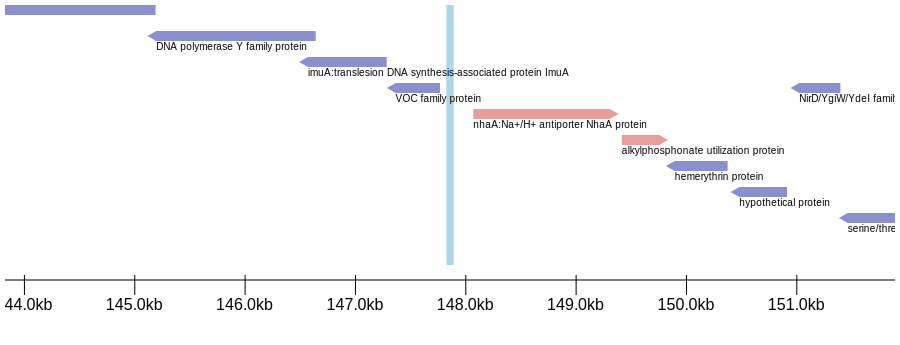

Match #359
E-value: 3.3e-05
%GC: 0.7
Score: 52.6
Genome Assembly: GCF_002797445.1_ASM279744v1
Target: NZ_PGEP01000001.1/1133330-1133399
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Acidovorax; unclassified Acidovorax
Matched Sequence: ACGCACAGGGUGUCGGCGCcGUGGUGGCCCGGCAGGUUUAUGCGCUGGUCGGGCCGCCUCGCGGUUUUUC


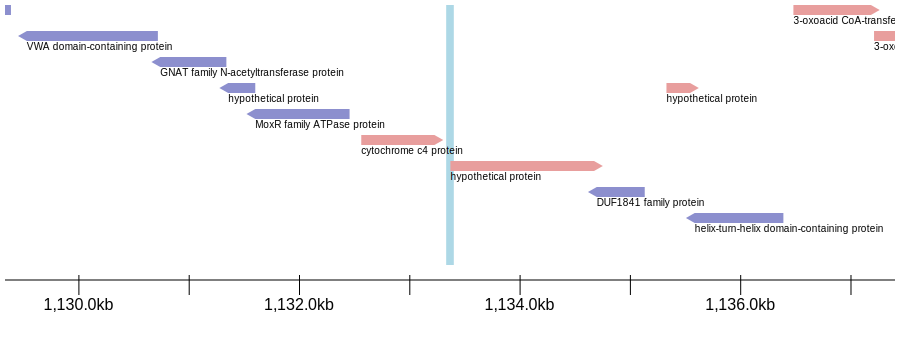

Match #362
E-value: 3.3e-05
%GC: 0.69
Score: 52.6
Genome Assembly: GCF_000218805.1_ASM21880v2
Target: NZ_AFPT01000081.1/508-574
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Acidovorax
Matched Sequence: CCAGCCAGGGUGUCGUCACAUGGGGUGCGGCAGGUGUAGCGAAGGUCGGGCCGCCUCGCGGAUCACU


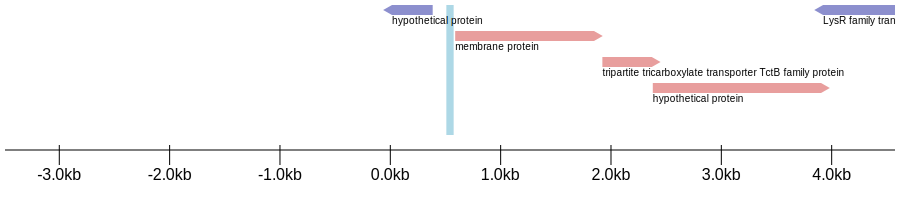

Match #368
E-value: 3.5e-05
%GC: 0.58
Score: 52.5
Genome Assembly: GCF_900115065.1_IMG-taxon_2599185172_annotated_assembly
Target: NZ_FOVE01000009.1/26430-26502
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Neisseriales; Chromobacteriaceae; Formivibrio
Matched Sequence: UCGUAUCGGGUGUCAGCAUcgGUGUUCGAUGCUACAGGUUCAUGCGAUGGUCGGGCCGCCAUUGCGGAGUGUU


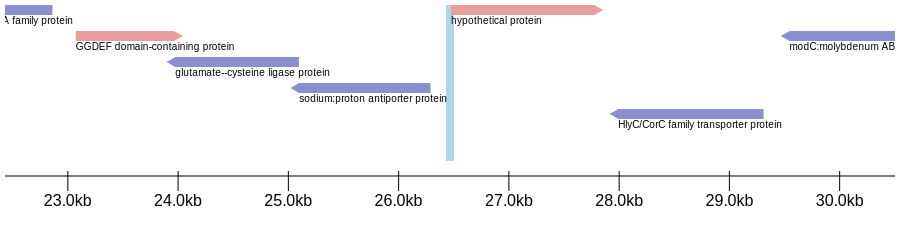

Match #369
E-value: 3.5e-05
%GC: 0.57
Score: 52.5
Genome Assembly: GCF_000968415.2_ASM96841v2
Target: NZ_CP011117.2/1131096-1131174
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas fluorescens group
Matched Sequence: UCCCCCUGGGUGCGUCGCUgcAUAAAGUACGGCGCAGGUUAAAAgccaagCAUUGGUCGGGCCGCCAAUGGAGAUUUGU


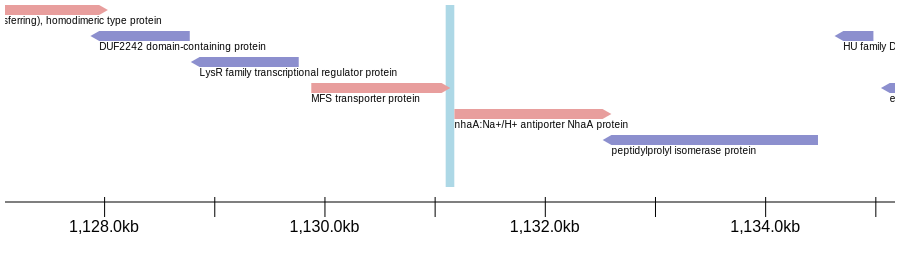

Match #381
E-value: 3.5e-05
%GC: 0.58
Score: 52.5
Genome Assembly: GCF_001005215.1_ASM100521v1
Target: NZ_LBNQ01000018.1/40619-40690
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Lampropedia
Matched Sequence: GCGCCUCGGGUUUCGGUUGcACUUGCAGCCGGGAGGUUUUUUgCAUUGGUCGGGCCGCCAGUGCAGAUUUUU


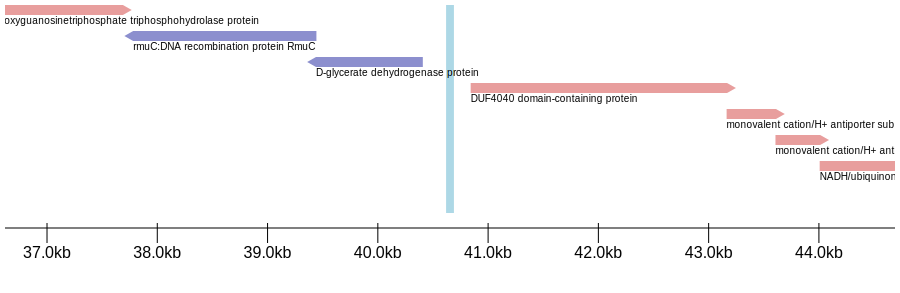

Match #383
E-value: 3.5e-05
%GC: 0.68
Score: 52.5
Genome Assembly: GCF_005503365.1_ASM550336v1
Target: NZ_SCML01000027.1/73490-73563
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Hydrogenophaga; unclassified Hydrogenophaga
Matched Sequence: UACCGUCGGGUGUUCGCGccgcAUGUUGCGGCGAAACAGGUUCAUGCGCUGGUCGGGCCGCCGCGCAGGAUUGC


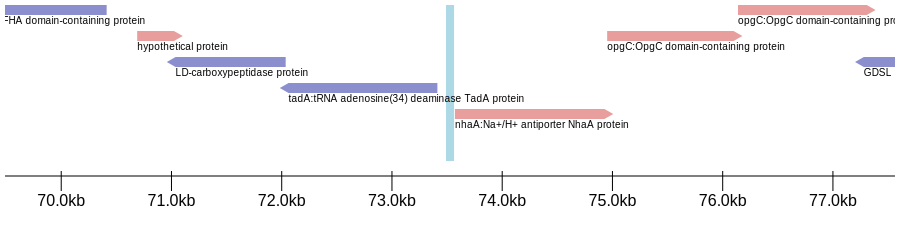

Match #389
E-value: 3.6e-05
%GC: 0.68
Score: 52.4
Genome Assembly: GCF_900107605.1_IMG-taxon_2675903230_annotated_assembly
Target: NZ_FNQJ01000013.1/20520-20588
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Acidovorax
Matched Sequence: UGGUGGCGGGUGUACGCGCcAGCAGGCGCGACAGGUUCAUGCGCUGGUCGGGCCGCCACGCGGUUUUUU


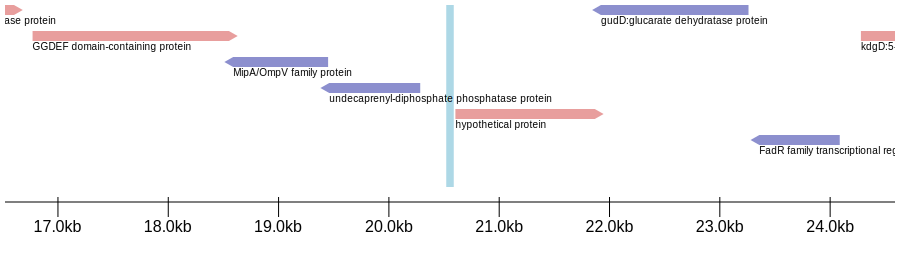

Match #394
E-value: 3.7e-05
%GC: 0.55
Score: 52.4
Genome Assembly: GCF_000313875.1_ASM31387v1
Target: NZ_AMXV01000027.1/7758-7839
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Alcaligenaceae; Alcaligenes; unclassified Alcaligenes
Matched Sequence: UUGCGCAGGGUGUUUUGCUggcAUGGUGCAGCAAGGCAGGUUAAUUacauaCGCAaGGUCGGGCCGCCuUGUGGAGAUUUGC


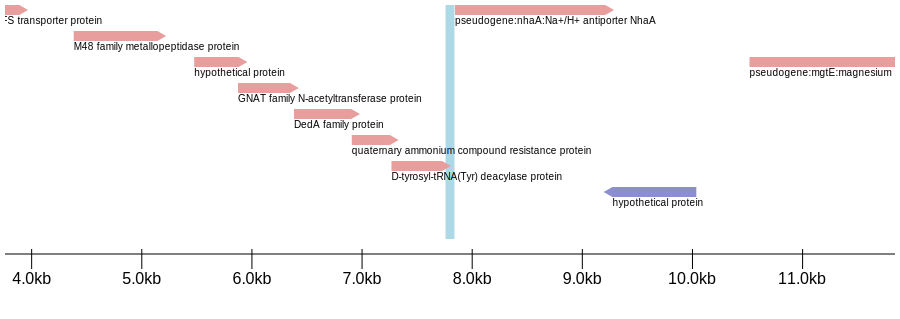

Match #424
E-value: 3.8e-05
%GC: 0.72
Score: 52.3
Genome Assembly: GCF_001020865.1_ASM102086v1
Target: NZ_LCZD01000019.1/22817-22892
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas fluorescens group
Matched Sequence: GCCGCCCGGGUGCCACCgcaACaacGCGGCAGGGCAGGUUUAAUucagCGCAGGUCGGGCCGCCGCGCGGAGUUCC


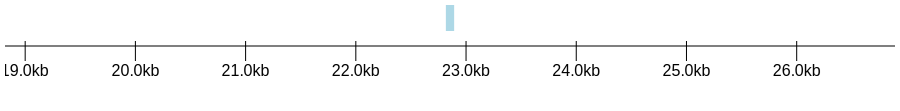

Match #429
E-value: 3.8e-05
%GC: 0.73
Score: 52.3
Genome Assembly: GCF_000342045.1_MagSO-1_1.0
Target: NZ_AONQ01000050.1/7998-8064
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Rhodospirillales; Rhodospirillaceae; Magnetospirillum
Matched Sequence: UCAUUCCGGGUGCCCGCAUCGGACGCGGGCAGGUUUUCGUGCCGGUCGGGCCGCCGCACGGGAGCCU


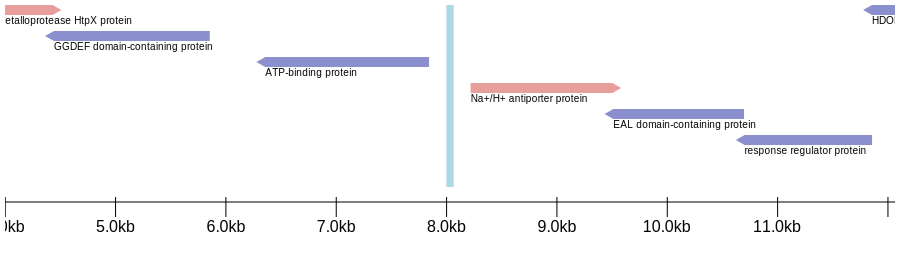

Match #431
E-value: 3.9e-05
%GC: 0.75
Score: 52.3
Genome Assembly: GCF_000244995.1_ASM24499v1
Target: NZ_CM001438.1/5095216-5095286
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; unclassified Burkholderiales
Matched Sequence: GCGUCCCGGGUGCUCCGCCaaGCCAUGGCGAGGCAGGUUCCAGCGAAGGUCGGGCCGCCUCGCAGCGCUGC


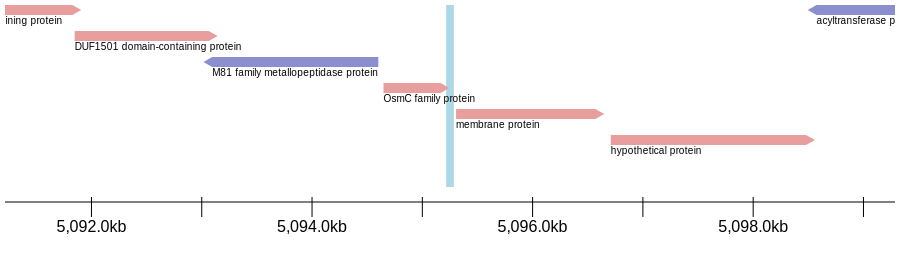

Match #432
E-value: 4.1e-05
%GC: 0.71
Score: 52.2
Genome Assembly: GCF_001566985.1_ASM156698v1
Target: NZ_LSMI01000090.1/118001-118073
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Alcaligenaceae; Achromobacter
Matched Sequence: CCGGGCUGGGUGUCAGGCGuaUUccuucGCGCUGGCAGGUCAACGCGAUGGUCGGGCCGCCACGCAGGAGCCC


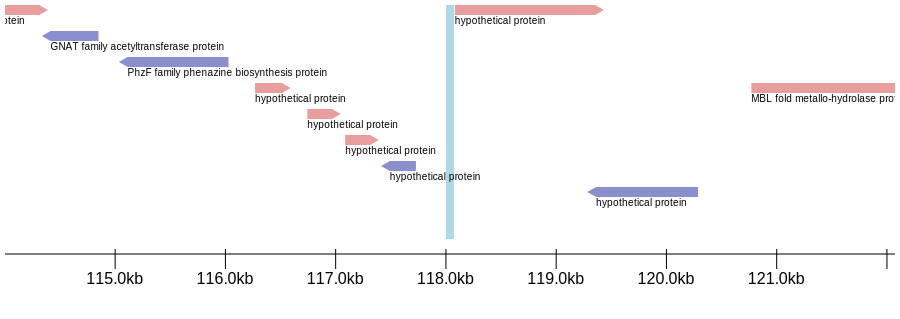

Match #433
E-value: 4.1e-05
%GC: 0.62
Score: 52.2
Genome Assembly: GCF_003688595.1_ASM368859v1
Target: NZ_RCWT01000002.1/3501-3568
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Sphingomonadales; Sphingomonadaceae; Sphingomonas; unclassified Sphingomonas
Matched Sequence: AGUUCGUGGGUGUUCGCGGAAUCCUGCGGACAGGUUUUGCGUUGGUCGGGCCGCCAGCGACGAAAGCU


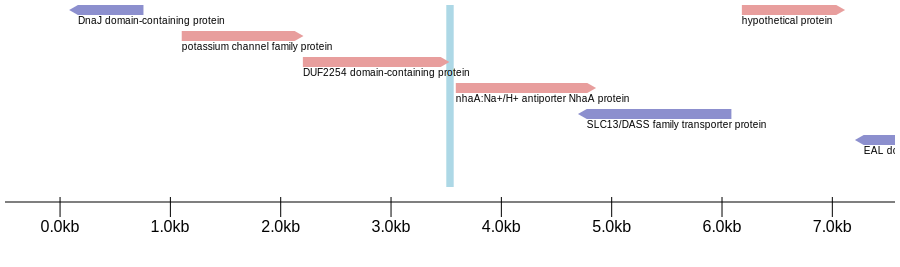

Match #434
E-value: 4.1e-05
%GC: 0.59
Score: 52.2
Genome Assembly: GCF_003852255.1_ASM385225v1
Target: NZ_CP027734.1/3387034-3387112
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; unclassified Pseudomonas
Matched Sequence: UCGCCCUGGGUGCGCUGCUgcAUACGGUACAGCGCAGGUUAAAGgauaagCGUUGGUCGGGCCGCCAAUGGAGAUCUGU


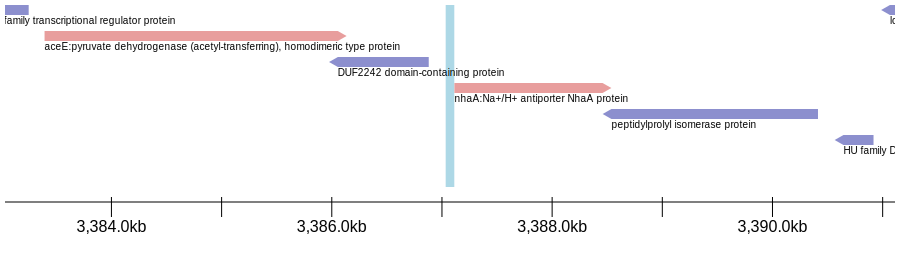

Match #437
E-value: 4.2e-05
%GC: 0.71
Score: 52.2
Genome Assembly: GCF_000022685.1_ASM2268v1
Target: NC_012811.1/1063774-1063845
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Rhizobiales; Methylobacteriaceae; Methylorubrum; Methylorubrum extorquens
Matched Sequence: CCCGGCAGGGUGUGCGGUCcggcaAUAGGAUCGGCAGGUCAAGCGUUGGUCGGGCCGCCAGCGCUGGAGACC


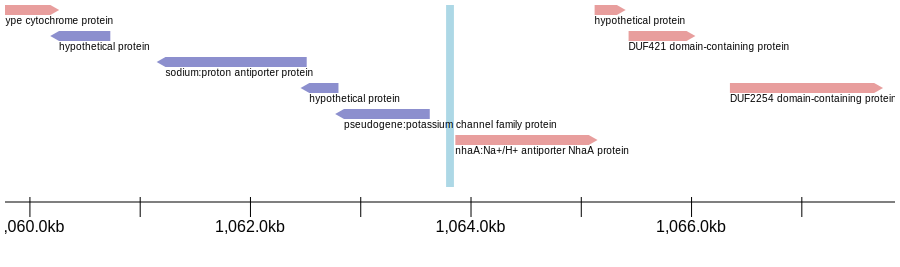

Match #438
E-value: 4.3e-05
%GC: 0.71
Score: 52.1
Genome Assembly: GCF_001421245.1_Leaf10
Target: NZ_LMKE01000029.1/35186-35261
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Sphingomonadales; Sphingomonadaceae; Sphingomonas; unclassified Sphingomonas
Matched Sequence: CGACACCGGGUGUUUGCUACCGGuacgccGGGGCAGGCAGGUUUCUACGCUGGUCGGGCCGCCAGCGCUGCCUGCC


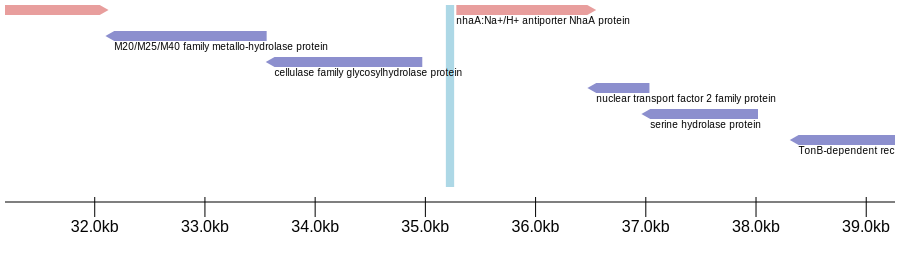

In [19]:
with open("{}/motif.list".format(outdir), "r") as motif_list_file:
    motif_list = motif_list_file.read().split('\n')
    
motif_list.remove("")
motif_list = ["{}/{}".format(untar_dir,motif) for motif in motif_list ]
for file in motif_list:
    renamed_file = "{}.sto".format(file)
    if not os.path.isfile(renamed_file):
        os.rename(file, renamed_file)
    run_rscape(outdir, renamed_file, fold=False, output=False)

## 6.5 Genome Context Images

Generates list of genome context images for each unique hit. RNA motif is shown in blue, genes are shown in purple or red depending on directionality.

Your match numbers may 'skip' (i.e. jumps from #1 to #4) - those missing are duplicates and were removed.

Match #442
E-value: 4.4e-05
%GC: 0.73
Score: 52.1
Genome Assembly: GCF_001556675.1_ASM155667v1
Target: NZ_LSJH01000158.1/4681-4750
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Burkholderiales genera incertae sedis; Xylophilus
Matched Sequence: GCAUGCUGGGUGUCCGGCUgCUUUCUGCCGGGCAGGUUCAUGCGCUGGUCGGGCCGCCGCGCGGUCGGAC


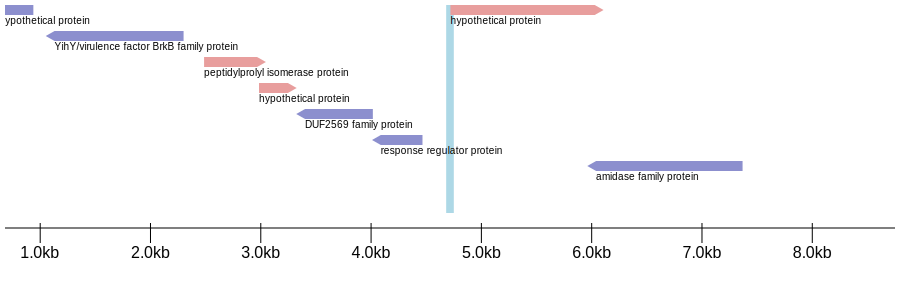

Match #443
E-value: 4.4e-05
%GC: 0.61
Score: 52.1
Genome Assembly: GCF_900104385.1_IMG-taxon_2615840603_annotated_assembly
Target: NZ_FNJA01000004.1/202130-202201
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Rhodoferax
Matched Sequence: UGCCAGCGGGUGCCCAGAgaAUGCUcUCUAUGUGGCAGGUUUAGCGAAGGUCGGGCCGCCUCGCAGCUUUAC


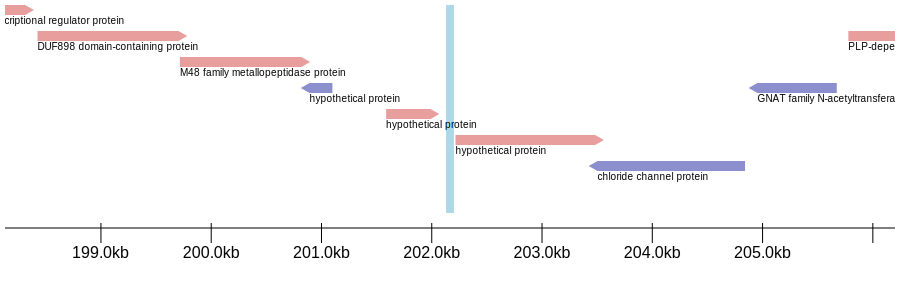

Match #494
E-value: 4.5e-05
%GC: 0.83
Score: 52.0
Genome Assembly: GCF_000215705.1_ASM21570v1
Target: NC_015677.1/1201942-1202010
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Ramlibacter; Ramlibacter tataouinensis
Matched Sequence: UGCCUGCGGGUGCGGCGCCGUGCGGGCGCCGCAGGUUCUCGCGCAGGUCGGGCCGCCGCGCGGCGUUCC


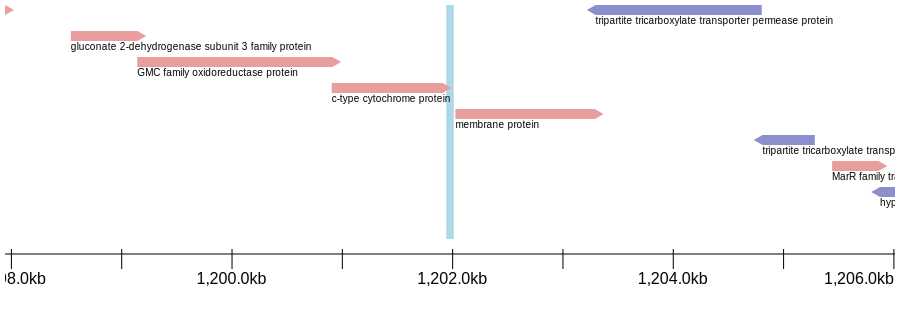

Match #500
E-value: 4.8e-05
%GC: 0.64
Score: 51.9
Genome Assembly: GCF_001557035.1_ASM155703v1
Target: NZ_LSKJ01000035.1/709-777
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Rhodospirillales; Rhodospirillaceae; unclassified Rhodospirillaceae
Matched Sequence: GAAAAGUGGGUGUCCGGACAUCGGUGCGGGCAGGGAUUAGCGCUGGUCGGGCCGCCAGCGAUGCUUUCU


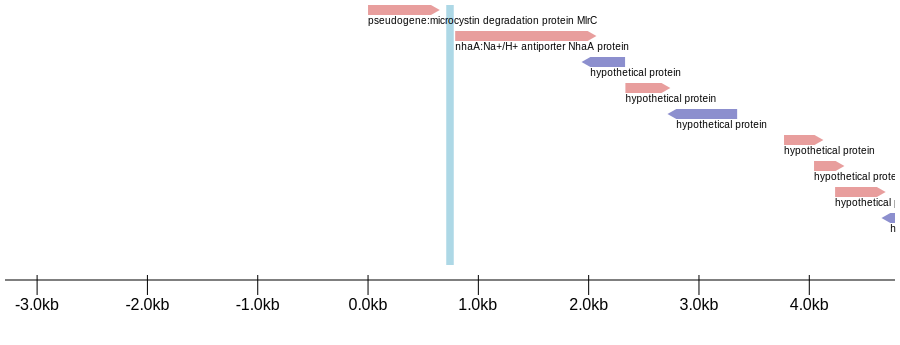

Match #503
E-value: 4.8e-05
%GC: 0.71
Score: 51.9
Genome Assembly: GCF_005144585.1_ASM514458v1
Target: NZ_SSMQ01000013.1/176633-176697
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Deltaproteobacteria; Myxococcales; Sorangiineae; Polyangiaceae; Polyangium
Matched Sequence: CAAGGAAGGGUGCAGCGACGGUCGCUGCAGGACCAAGGAUGGUCGGGCCGCCAUCCCAGCCGGCG


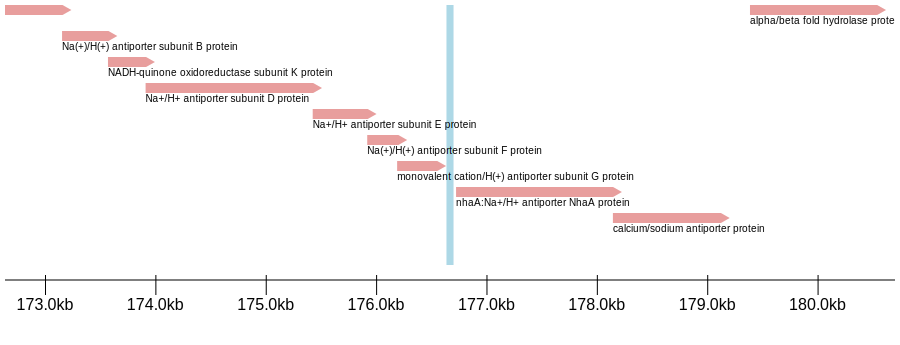

Match #504
E-value: 4.9e-05
%GC: 0.57
Score: 51.9
Genome Assembly: GCF_009659625.1_ASM965962v1
Target: NZ_VOIW01000002.1/253700-253778
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas
Matched Sequence: UCACCCUGGGUGCGUCGCUgcAUAAGGUACGGCGCAGGUUAAAUgccaagCAUUGGUCGGGCCGCCAAUGGAGAUUUGU


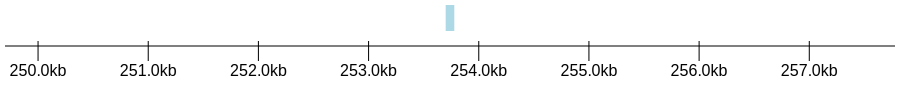

Match #506
E-value: 4.9e-05
%GC: 0.71
Score: 51.9
Genome Assembly: GCF_003201865.1_ASM320186v1
Target: NZ_QJJJ01000008.1/41438-41510
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Rhizobiales; Methylobacteriaceae; Methylobacterium; unclassified Methylobacterium
Matched Sequence: GCCGCCUGGGUGCGCGGUCcgAUGAUUGGACCGGCAGGUUUCUGCGCUGGUCGGGCCGCCAGCAGCAGGGAAC


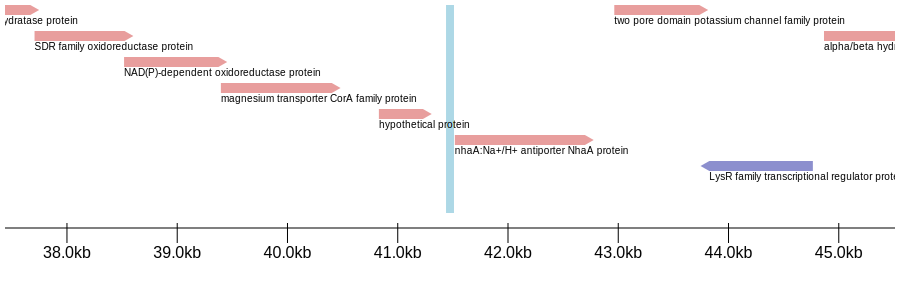

Match #518
E-value: 5.1e-05
%GC: 0.67
Score: 51.8
Genome Assembly: GCF_001477315.1_ASM147731v1
Target: NZ_LDTC01000002.1/20659-20727
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Sphingomonadales; Sphingomonadaceae; Sphingomonas
Matched Sequence: CGCCCCAGGGUGUUCGUGGAGCAGACACGGGCAGGAUGAUCGUUGGUCGGGCCGCCAGCGACGAUGAAC


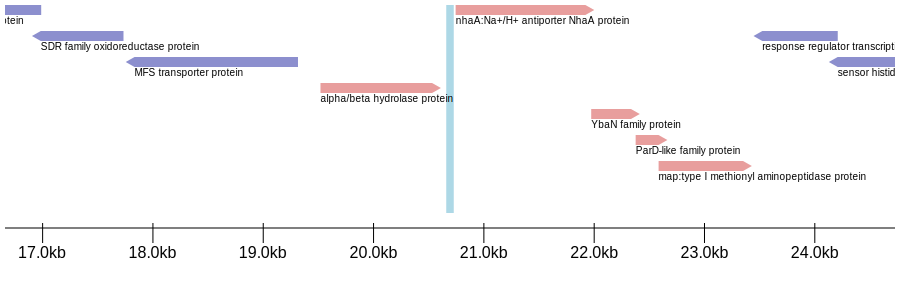

Match #521
E-value: 5.2e-05
%GC: 0.69
Score: 51.8
Genome Assembly: GCF_003633835.1_ASM363383v1
Target: NZ_RBIT01000001.1/113039-113108
Lineage: cellular organisms; Bacteria; Proteobacteria; Betaproteobacteria; Burkholderiales; Comamonadaceae; Acidovorax; unclassified Acidovorax
Matched Sequence: GGAAGCUGGGUGUCGGCGCcAUGGUGGCCUGGCAGGUUCAUGCGCUGGUCGGGCCGCCACGCGGUUUUUC


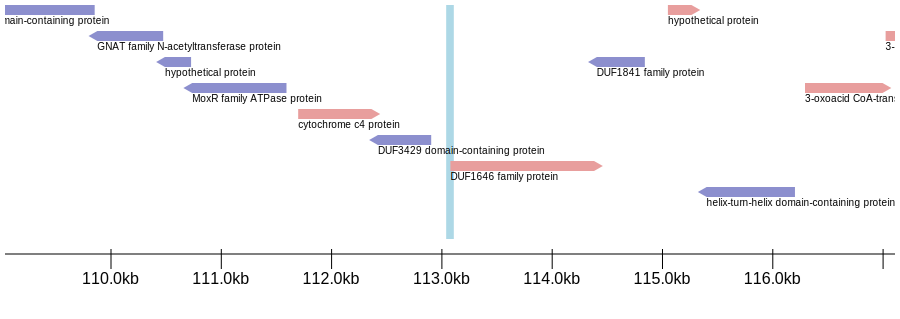

Match #523
E-value: 5.400000000000001e-05
%GC: 0.76
Score: 51.7
Genome Assembly: GCF_900113485.1_IMG-taxon_2651870128_annotated_assembly
Target: NZ_FOPM01000003.1/262374-262445
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Rhizobiales; Methylobacteriaceae; Methylobacterium
Matched Sequence: CCGGUCAGGGUGCGCGGUCcGUGGUuCGGACCGGCAGGACACGCGUUGGUCGGGCCGCCAGCGCCGGAGACC


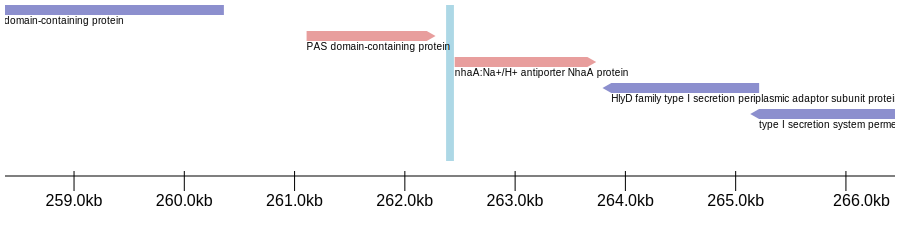

Match #529
E-value: 5.5e-05
%GC: 0.7
Score: 51.7
Genome Assembly: GCF_001476385.1_ASM147638v1
Target: NZ_LDSO01000010.1/47467-47543
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas
Matched Sequence: GGCCGCUGGGUGUCGCCgcaAUCGUGCGGUAGGACAGGUUUAACgucagCGCAGGUCGGGCCGCCGCGCGGAGUUCG


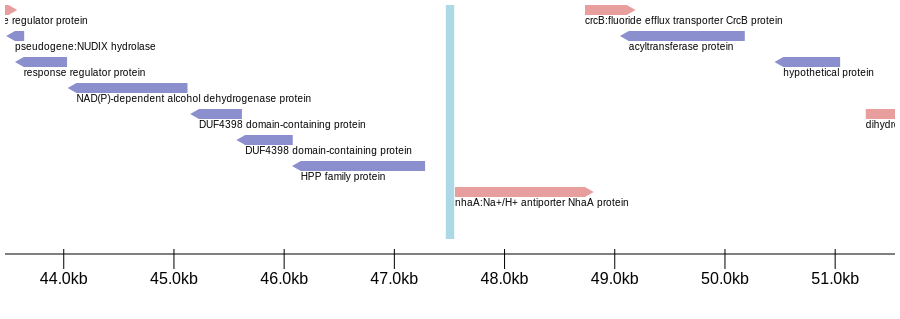

Match #542
E-value: 5.5e-05
%GC: 0.66
Score: 51.7
Genome Assembly: GCF_000970465.2_ASM97046v2
Target: NZ_LAJE02000173.1/28322-28391
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Rhizobiales; Hyphomicrobiaceae; Devosia; Devosia insulae
Matched Sequence: AGGCUCUGGGUGUCUCCGAcgCACGGUCGCAGGCAGGUAUACGUUGGUCGGGCCGCCAACGGGCAUUUCC


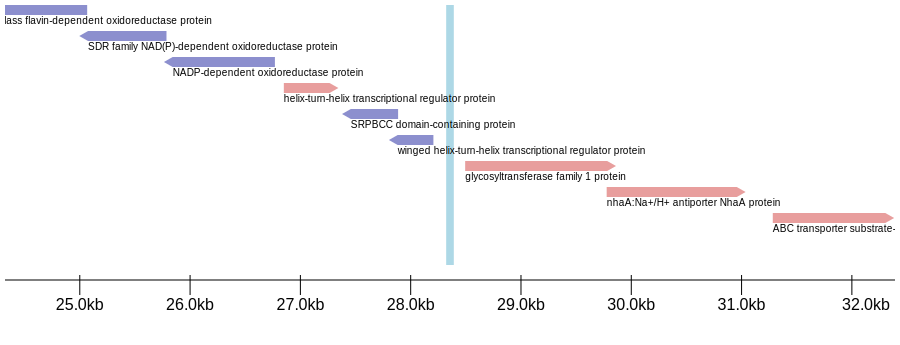

Match #544
E-value: 5.5e-05
%GC: 0.67
Score: 51.7
Genome Assembly: GCF_001440475.1_ASM144047v1
Target: NZ_LLYB01000071.1/367174-367242
Lineage: cellular organisms; Bacteria; Proteobacteria; Alphaproteobacteria; Rhizobiales; Bradyrhizobiaceae; Bradyrhizobium
Matched Sequence: GGCGUUCGGGUGCUCGCUGcAUUGAGCAGCGACAGGUUAAGCGAUGGUCGGGCCGCCACGCGGAAAGCG


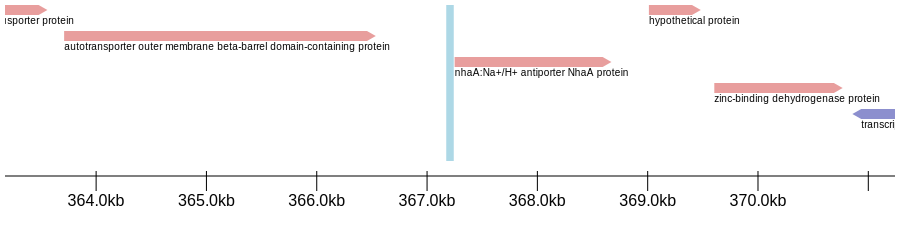

Match #545
E-value: 5.600000000000001e-05
%GC: 0.74
Score: 51.7
Genome Assembly: GCF_003732345.1_ASM373234v1
Target: NZ_MOBS01000007.1/226528-226603
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas fluorescens group
Matched Sequence: GCCGCCCGGGUGCCACCgcaACaacGCGGCAGGGCAGGUUUAAUucagCGCAGGUCGGGCCGCCGCGCGGAGUCGC


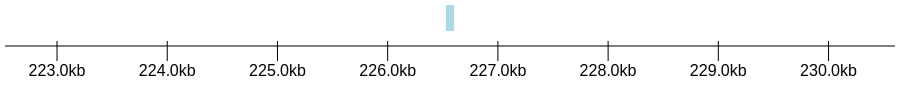

Match #547
E-value: 5.600000000000001e-05
%GC: 0.58
Score: 51.7
Genome Assembly: GCF_000876155.1_ASM87615v1
Target: NZ_JXCQ01000017.1/6579-6657
Lineage: cellular organisms; Bacteria; Proteobacteria; Gammaproteobacteria; Pseudomonadales; Pseudomonadaceae; Pseudomonas; Pseudomonas fluorescens group
Matched Sequence: CCCCCCUGGGUGCGUCGCUgcAUAAAGUACGGCGCAGGUUAAAAgccaagCAUUGGUCGGGCCGCCAAUGGAGAUUUGU


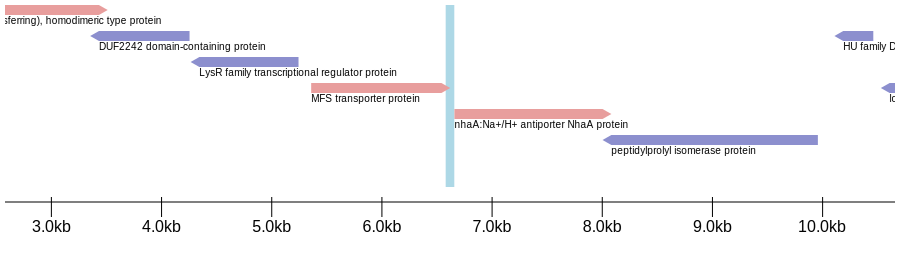

Match #551
E-value: 5.7e-05
%GC: 0.71
Score: 51.6
Genome Assembly: GCF_009649845.1_ASM964984v1
Target: NZ_WJIE01000003.1/839607-839671
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Deltaproteobacteria; Myxococcales; Sorangiineae; Polyangiaceae; Polyangium
Matched Sequence: CAUGGAAGGGUGCAGCGACGGUCGCUGCAGGAUCGAGGAUGGUCGGGCCGCCAUCCGAGCCGGCG


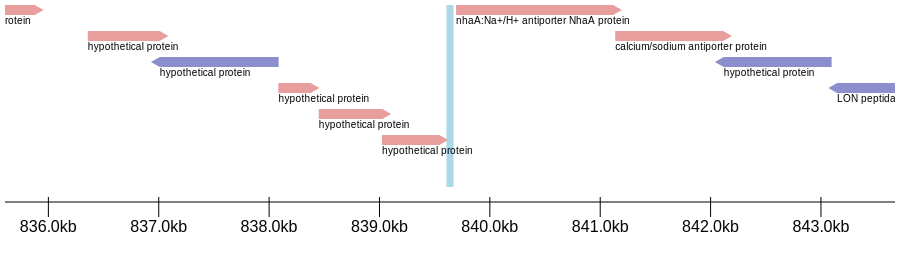

RuntimeError: BLOB ID IS NOT IMPLEMENTED

In [11]:
deduped_sto_records = [record for record in sto_records if record.id in dedupe_id_list]
results_csv_filename = "{}/{}_results.csv".format(outdir, motif_name)
if not os.path.exists(results_csv_filename):
    deduped_results_df['lineage']=''
    deduped_results_df['assembly_accession']=''
    deduped_results_df.to_csv(results_csv_filename)
get_all_images(results_csv_filename, deduped_sto_records)